# Playground Notebook For Quantizing VLP Models

## Initialize the Distributed Backend

In [44]:
import os
import torch
import pytorch_lightning as pl
import configs
import copy
from sensitivity_utils import get_quantization_config, print_size_of_model, SmallMTDataModuleMETER, SmallMTDataModuleVILT
# from vilt.datamodules.multitask_datamodule import MTDataModule as MTDataModuleVILT
# from meter.datamodules.multitask_datamodule import MTDataModule as MTDataModuleMeter

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from copy import deepcopy



# Limit the number of CPUs
os.environ["OMP_NUM_THREADS"] = "8"  # Set this to the number of CPUs you want to use
os.environ["MKL_NUM_THREADS"] = "8"  # Set this to the number of CPUs you want to use

In [45]:
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="promote has been superseded by promote_options='default'")
warnings.filterwarnings("ignore", category=FutureWarning, message="Importing from timm.models.helpers is deprecated")
warnings.filterwarnings("ignore", category=FutureWarning, message="Importing from timm.models.layers is deprecated")
warnings.filterwarnings("ignore", category=FutureWarning, message="Importing from timm.models.registry is deprecated")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_small_patch16_224 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_base_patch16_224 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_base_patch32_224 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_base_patch16_384 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_base_patch32_384 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_large_patch16_224 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_large_patch32_224 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_large_patch16_384 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_large_patch32_384 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_base_patch16_224_in21k in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_base_patch32_224_in21k in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_large_patch16_224_in21k in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_large_patch32_224_in21k in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_huge_patch14_224_in21k in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_base_resnet50_224_in21k in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_base_resnet50_384 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_small_resnet26d_224 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_base_resnet26d_224 in registry")
warnings.filterwarnings("ignore", category=UserWarning, message="Overwriting vit_base_resnet50d_224 in registry")
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")

### Define the Configuration to Initialize the Datamodule and Model

In [46]:
# Set the configuration
_config = configs.vilt_config_nlvr2
_config["batch_size"] = 64
_config["per_gpu_batchsize"] = 64


pl.seed_everything(_config["seed"])

Seed set to 0


0

## Initialize the Datamodule

Select the configuration and initialize the test and full datamodule

In [47]:
# ==========================================
# ========= Create full datamodule =========
# ==========================================
if "meter" in _config["model"]:
    infer_dm = SmallMTDataModuleMETER(_config, dist=False, num_samples=5, start_idx=0)
    infer_dm.setup("test")
    infer_dataloader = infer_dm.test_dataloader()

elif "vilt" in _config["model"]:
    infer_dm = SmallMTDataModuleVILT(_config, dist=False, num_samples=32, start_idx=0)
    infer_dm.setup("test", is_random=True)
    infer_dataloader = infer_dm.test_dataloader()

else:
    raise ValueError("Model not supported: ", _config["model"])

print(f"Batch size: {_config['batch_size']}")

Batch size: 64


## Initialize The Model

In [48]:
from vilt.modules import ViLTransformerSS
from meter.modules import METERTransformerSS

if _config["model"] == "vilt":
    model = ViLTransformerSS(_config)
    print("Initialized ViLT model")

elif _config["model"] == "meter":
    model = METERTransformerSS(_config)
    print("Initialized METER model")

else:
    raise ValueError("Model not supported: ", _config["model"])

Initialized ViLT model


# Quantize the Model

In [49]:
print("Full Precision Model:")
print_size_of_model(model)

quantization_config, embedding_config = get_quantization_config(2)

layer_to_quantize = "transformer.blocks"
if "embeddings" in layer_to_quantize:
            quantization_config = embedding_config


model_dynamic = copy.deepcopy(model)
torch.quantization.quantize_dynamic(
    model_dynamic, {layer_to_quantize: quantization_config}, inplace=True
)

# print(model_dynamic)
print("Size after quantization:")
print_size_of_model(model_dynamic)

Full Precision Model:
Size of the model (MB): 455.900978
Size after quantization:
Size of the model (MB): 201.132882


In [50]:
def get_module_by_path(model, path):
    """
    Access a module in the model by specifying the path as a string.
    
    Args:
        model (nn.Module): The PyTorch model.
        path (str): The path to the module, e.g., "transformer.blocks[0].attn.qkv".
    
    Returns:
        nn.Module: The module at the specified path.
    """
    parts = path.split('.')
    current_module = model
    
    for part in parts:
        if '[' in part and ']' in part:
            # Handle list indexing, e.g., "blocks[0]"
            module_name, index = part.split('[')
            index = int(index[:-1])  # Remove the closing bracket and convert to int
            current_module = getattr(current_module, module_name)[index]
        else:
            # Handle regular attribute access
            current_module = getattr(current_module, part)
    
    return current_module

# Example usage
module_path = "transformer.blocks[0].mlp.fc2"
qkv_module = get_module_by_path(model, module_path)
print(qkv_module)

Linear(in_features=3072, out_features=768, bias=True)


In [51]:
input_ = next(iter(infer_dataloader))
print(input_.keys())
# print(input_["answers"])
print(f"Number of batches: {len(infer_dataloader)}")
print(f"Smaples in a batch: {len(input_['answers'])}")

dict_keys(['answers', 'image_0', 'image_1', 'text', 'table_name', 'text_ids', 'text_labels', 'text_ids_mlm', 'text_labels_mlm', 'text_masks'])
Number of batches: 1
Smaples in a batch: 32


In [52]:
# import torch

# def get_attention_maps(model, batch):
#     """Extract attention weights from all blocks."""
#     attention_maps = {}
    
#     # Register hooks to capture attention weights
#     hooks = []
#     for i in range(12):
#         block = model.transformer.blocks[i].attn
#         hook = block.register_forward_hook(
#             lambda module, input, output, block_idx=i: attention_maps.__setitem__(f'block_{block_idx}', output[1].detach())
#         )
#         hooks.append(hook)
    
#     # Forward pass (replace with your ViLT input format)
#     with torch.no_grad():
#         infer1 = model.infer( 
#             batch, mask_text=False, mask_image=False, image_token_type_idx=1
#         )
    
#     # Remove hooks
#     for hook in hooks:
#         hook.remove()
    
#     return attention_maps

# # Get attention maps for both models
# attn_full = get_attention_maps(model, input_)

In [53]:
# import torch
# import torch.nn.functional as F
# import math

# def weighted_variance_change(full_var, quant_var):
#     """Calculate weighted variance change."""
#     percent_change = ((quant_var - full_var) / full_var) * 100
#     return percent_change * math.log(full_var)

# def analyze_attention_activations(model, model_quant, batch, block):
#     """Compare activations of attention sub-modules for a specific block."""
#     # Get attention maps for full-precision and quantized models
#     attn_full = get_attention_maps(model, batch)
#     attn_quant = get_attention_maps(model_quant, batch)
    
#     # Extract attention outputs for the specified block
#     attn_full_block = attn_full[f'block_{block}']
#     attn_quant_block = attn_quant[f'block_{block}']
    
#     # Compute MSE and Cosine Similarity
#     mse = F.mse_loss(attn_full_block, attn_quant_block).item()
#     cosine = F.cosine_similarity(attn_full_block.flatten(), attn_quant_block.flatten(), dim=0).item()
    
#     # Compute mean and variance
#     full_mean = attn_full_block.mean().item()
#     full_var = attn_full_block.var().item()
#     quant_mean = attn_quant_block.mean().item()
#     quant_var = attn_quant_block.var().item()
    
#     # Percent changes in mean and variance
#     def percent_change(full, quant):
#         return ((quant - full) / full) * 100
    
#     mean_change = percent_change(full_mean, quant_mean)
#     var_change = percent_change(full_var, quant_var)
    
#     # Weighted variance change
#     var_weighted_change = weighted_variance_change(full_var, quant_var)
    
#     # Return results
#     return {
#         'mse': mse,
#         'cosine': cosine,
#         'stats': {
#             'full_mean': full_mean,
#             'full_var': full_var,
#             'quant_mean': quant_mean,
#             'quant_var': quant_var,
#             'mean_change': mean_change,
#             'var_change': var_change,
#             'var_weighted_change': var_weighted_change,
#         }
#     }

# # Example usage

In [54]:
# for i in range(12):

#     # Quantize MLP layers (fc1 and fc2)
#     layer_to_quantize = f"transformer.blocks.{i}.mlp"
#     model_dynamic = deepcopy(model)
#     torch.quantization.quantize_dynamic(
#         model_dynamic, {layer_to_quantize: quantization_config}, inplace=True
#     )

#     results = analyze_attention_activations(model, model_dynamic, batch=input_, block=0)
#     print(f"Block {i} attn, {results['mse']:.6f}, {results['cosine']:.6f}, {results['stats']['mean_change']:.2f}, {results['stats']['var_change']:.2f}, {results['stats']['var_weighted_change']:.6f}")
    
#     print(f"Block {i} Attention Metrics:")
#     print(f"  MSE: {results['mse']:.6f}")
#     print(f"  Cosine Similarity: {results['cosine']:.6f}")
#     print(f"  Mean: Full={results['stats']['full_mean']:.6f}, Quant={results['stats']['quant_mean']:.6f}, Change={results['stats']['mean_change']:.2f}%")
#     print(f"  Variance: Full={results['stats']['full_var']:.6f}, Quant={results['stats']['quant_var']:.6f}, Change={results['stats']['var_change']:.2f}%")
#     print(f"  Weighted Variance Change: {results['stats']['var_weighted_change']:.6f}")

In [55]:
import torch
import torch.nn.functional as F

def analyze_attention_activations(full_model, quant_model, batch, block):
    # Forward pass through full precision model
    with torch.no_grad():
        x, co_masks = model.get_co_embeds(batch)
        x_quant, co_masks_quant = quant_model.get_co_embeds(batch)

    with torch.no_grad():
        full_outputs = full_model.transformer.blocks[block].attn.modified_forward(x, co_masks)
        full_qkv = full_outputs[2]  # qkv output
        full_proj = full_outputs[0]  # proj output

    # Forward pass through quantized model
    with torch.no_grad():
        quant_outputs = quant_model.transformer.blocks[block].attn.modified_forward(x_quant, co_masks_quant)
        quant_qkv = quant_outputs[2]  # qkv output
        quant_proj = quant_outputs[0]  # proj output

    # Compute metrics for qkv
    qkv_mse = F.mse_loss(full_qkv, quant_qkv).item()
    qkv_cosine = F.cosine_similarity(full_qkv.flatten(), quant_qkv.flatten(), dim=0).item()

    # Compute metrics for proj
    proj_mse = F.mse_loss(full_proj, quant_proj).item()
    proj_cosine = F.cosine_similarity(full_proj.flatten(), quant_proj.flatten(), dim=0).item()

    # Compute statistics
    def compute_stats(full, quant):
        full_mean = full.mean().item()
        quant_mean = quant.mean().item()
        mean_change = abs((quant_mean - full_mean) / full_mean) * 100

        full_var = full.var().item()
        quant_var = quant.var().item()
        var_change = abs((quant_var - full_var) / full_var) * 100

        var_weighted_change = abs((quant_var - full_var) / full_var) * full_var
        return {
            "full_mean": full_mean,
            "quant_mean": quant_mean,
            "mean_change": mean_change,
            "full_var": full_var,
            "quant_var": quant_var,
            "var_change": var_change,
            "var_weighted_change": var_weighted_change,
        }

    qkv_stats = compute_stats(full_qkv, quant_qkv)
    proj_stats = compute_stats(full_proj, quant_proj)

    return {
        "qkv": {"mse": qkv_mse, "cosine": qkv_cosine, "stats": qkv_stats},
        "proj": {"mse": proj_mse, "cosine": proj_cosine, "stats": proj_stats},
    }

In [56]:
for i in range(12):
    layer_to_quantize = f"transformer.blocks.{i}.attn.qkv"
    model_dynamic = deepcopy(model)
    torch.quantization.quantize_dynamic(
        model_dynamic, {layer_to_quantize: quantization_config}, inplace=True
    )

    results = analyze_attention_activations(model, model_dynamic, batch=input_, block=i)
    print(f"Block {i} Attention, {results['qkv']['mse']:.6f}, {results['qkv']['cosine']:.6f}, {results['qkv']['stats']['mean_change']:.2f}, {results['qkv']['stats']['var_change']:.2f}, {results['qkv']['stats']['var_weighted_change']:.6f}")

    # print(f"Block {i} Attention Metrics:")
    # print("  qkv Layer:")
    # print(f"    MSE: {results['qkv']['mse']:.6f}")
    # print(f"    Cosine Similarity: {results['qkv']['cosine']:.6f}")
    # print(f"    Mean: Full={results['qkv']['stats']['full_mean']:.6f}, Quant={results['qkv']['stats']['quant_mean']:.6f}, Change={results['qkv']['stats']['mean_change']:.2f}%")
    # print(f"    Variance: Full={results['qkv']['stats']['full_var']:.6f}, Quant={results['qkv']['stats']['quant_var']:.6f}, Change={results['qkv']['stats']['var_change']:.2f}%")
    # print(f"    Weighted Variance Change: {results['qkv']['stats']['var_weighted_change']:.6f}")

for i in range(12):
    layer_to_quantize = f"transformer.blocks.{i}.attn.proj"
    model_dynamic = deepcopy(model)
    torch.quantization.quantize_dynamic(
        model_dynamic, {layer_to_quantize: quantization_config}, inplace=True
    )

    results = analyze_attention_activations(model, model_dynamic, batch=input_, block=i)

    print(f"Block {i} Projection, {results['proj']['mse']:.6f}, {results['proj']['cosine']:.6f}, {results['proj']['stats']['mean_change']:.2f}, {results['proj']['stats']['var_change']:.2f}, {results['proj']['stats']['var_weighted_change']:.6f}")

    # print("  proj Layer:")
    # print(f"    MSE: {results['proj']['mse']:.6f}")
    # print(f"    Cosine Similarity: {results['proj']['cosine']:.6f}")
    # print(f"    Mean: Full={results['proj']['stats']['full_mean']:.6f}, Quant={results['proj']['stats']['quant_mean']:.6f}, Change={results['proj']['stats']['mean_change']:.2f}%")
    # print(f"    Variance: Full={results['proj']['stats']['full_var']:.6f}, Quant={results['proj']['stats']['quant_var']:.6f}, Change={results['proj']['stats']['var_change']:.2f}%")
    # print(f"    Weighted Variance Change: {results['proj']['stats']['var_weighted_change']:.6f}")

Block 0 Attention, 94.142311, 0.397765, 98.56, 86.21, 96.145194
Block 1 Attention, 44.568481, 0.515301, 596.67, 81.34, 48.787571
Block 2 Attention, 26.362907, 0.535883, 7.76, 75.60, 27.799153
Block 3 Attention, 20.379688, 0.430226, 835.50, 82.51, 20.599298
Block 4 Attention, 15.509605, 0.478627, 314.69, 69.45, 13.839821
Block 5 Attention, 13.981157, 0.438306, 53.39, 74.82, 12.857333
Block 6 Attention, 12.614777, 0.492729, 9.05, 54.18, 8.612648
Block 7 Attention, 12.417482, 0.539829, 14.69, 59.59, 10.274692
Block 8 Attention, 11.680265, 0.654735, 17.83, 39.35, 7.792399
Block 9 Attention, 11.906795, 0.743754, 338.75, 40.23, 10.608300
Block 10 Attention, 12.455453, 0.810425, 10.16, 35.62, 12.823778
Block 11 Attention, 13.866129, 0.771899, 23.63, 36.03, 12.223652
Block 0 Projection, 182.900299, 0.109576, 99.59, 98.70, 182.700318
Block 1 Projection, 151.208725, 0.245916, 101.59, 94.47, 152.017388
Block 2 Projection, 116.440628, 0.355134, 96.29, 56.95, 68.740341
Block 3 Projection, 133.46646

In [57]:
def kl_divergence(attn_full, attn_quant):
    # Ensure numerical stability
    eps = 1e-8
    attn_full = attn_full + eps
    attn_quant = attn_quant + eps
    return (attn_full * (attn_full.log() - attn_quant.log())).sum(dim=-1).mean().item()

In [58]:
def effective_rank(matrix):
    s = torch.linalg.svdvals(matrix)
    s_norm = s / s.sum()
    return (-s_norm * torch.log(s_norm)).sum().item()  # Shannon entropy of singular values

In [59]:
def mutual_information(x_full, x_quant, bins=100):
    # Histogram-based MI estimation (for simplicity)
    joint = torch.histc(torch.cat([x_full, x_quant], dim=0), bins=bins)
    marginal_full = torch.histc(x_full, bins=bins)
    marginal_quant = torch.histc(x_quant, bins=bins)
    # Compute MI (crude approximation)
    return torch.sum(joint * torch.log(joint / (marginal_full * marginal_quant))).item()

In [60]:
def analyze_attention_activations_advanced(full_model, quant_model, batch, block):
    # Forward pass through full precision model
    with torch.no_grad():
        x, co_masks = model.get_co_embeds(batch)
        x_quant, co_masks_quant = quant_model.get_co_embeds(batch)

    with torch.no_grad():
        full_outputs = full_model.transformer.blocks[block].attn.modified_forward(x, co_masks)
        full_attn = full_outputs[1]  # Attention matrix
        full_qkv = full_outputs[2]   # qkv output
        full_proj = full_outputs[0]  # proj output

    # Forward pass through quantized model
    with torch.no_grad():
        quant_outputs = quant_model.transformer.blocks[block].attn.modified_forward(x_quant, co_masks_quant)
        quant_attn = quant_outputs[1]
        quant_qkv = quant_outputs[2]
        quant_proj = quant_outputs[0]

    # Compute advanced metrics
    metrics = {
        "attn_kl_div": kl_divergence(full_attn, quant_attn),
        "qkv_rank_full": effective_rank(full_qkv),
        "qkv_rank_quant": effective_rank(quant_qkv),
        "mi_qkv": mutual_information(full_qkv, quant_qkv),
        "mi_proj": mutual_information(full_proj, quant_proj),
    }
    return metrics

In [61]:
for i in range(12):
    layer_to_quantize = f"transformer.blocks.{i}.attn.qkv"
    model_dynamic = deepcopy(model)
    torch.quantization.quantize_dynamic(
        model_dynamic, {layer_to_quantize: quantization_config}, inplace=True
    )

    results = analyze_attention_activations_advanced(model, model_dynamic, batch=input_, block=i)
    print(f"Block {i} Attention, {results['attn_kl_div']:.6f}, {results['qkv_rank_full']:.6f}, {results['qkv_rank_quant']:.2f}, {results['mi_qkv']:.2f}, {results['mi_proj']:.6f}")

    # print(f"Block {i} Attention Metrics:")
    # print("  qkv Layer:")
    # print(f"    MSE: {results['qkv']['mse']:.6f}")
    # print(f"    Cosine Similarity: {results['qkv']['cosine']:.6f}")
    # print(f"    Mean: Full={results['qkv']['stats']['full_mean']:.6f}, Quant={results['qkv']['stats']['quant_mean']:.6f}, Change={results['qkv']['stats']['mean_change']:.2f}%")
    # print(f"    Variance: Full={results['qkv']['stats']['full_var']:.6f}, Quant={results['qkv']['stats']['quant_var']:.6f}, Change={results['qkv']['stats']['var_change']:.2f}%")
    # print(f"    Weighted Variance Change: {results['qkv']['stats']['var_weighted_change']:.6f}")

for i in range(12):
    layer_to_quantize = f"transformer.blocks.{i}.attn.proj"
    model_dynamic = deepcopy(model)
    torch.quantization.quantize_dynamic(
        model_dynamic, {layer_to_quantize: quantization_config}, inplace=True
    )

    results = analyze_attention_activations_advanced(model, model_dynamic, batch=input_, block=i)

    print(f"Block {i} Projection, {results['attn_kl_div']:.6f}, {results['qkv_rank_full']:.6f}, {results['qkv_rank_quant']:.2f}, {results['mi_qkv']:.2f}, {results['mi_proj']:.6f}")

    # print("  proj Layer:")
    # print(f"    MSE: {results['proj']['mse']:.6f}")
    # print(f"    Cosine Similarity: {results['proj']['cosine']:.6f}")
    # print(f"    Mean: Full={results['proj']['stats']['full_mean']:.6f}, Quant={results['proj']['stats']['quant_mean']:.6f}, Change={results['proj']['stats']['mean_change']:.2f}%")
    # print(f"    Variance: Full={results['proj']['stats']['full_var']:.6f}, Quant={results['proj']['stats']['quant_var']:.6f}, Change={results['proj']['stats']['var_change']:.2f}%")
    # print(f"    Weighted Variance Change: {results['proj']['stats']['var_weighted_change']:.6f}")

Block 0 Attention, 5.473498, 10.538170, nan, nan, nan
Block 1 Attention, 8.067818, 10.451906, nan, inf, nan
Block 2 Attention, 11.184557, 10.635757, nan, nan, nan
Block 3 Attention, 9.646361, 10.752354, 10.08, nan, nan
Block 4 Attention, 10.046512, 10.800952, 10.62, nan, nan
Block 5 Attention, 9.640711, 10.854957, 10.49, nan, nan
Block 6 Attention, 10.665472, 10.888416, 10.80, nan, nan
Block 7 Attention, 7.525283, 10.884445, 10.41, nan, nan
Block 8 Attention, 8.646447, 10.857976, 10.62, nan, nan
Block 9 Attention, 6.945306, 10.804218, 9.47, nan, nan
Block 10 Attention, 5.300538, 10.738180, nan, nan, nan
Block 11 Attention, 5.183421, 10.725655, nan, inf, nan
Block 0 Projection, 5.580882, 10.538271, 10.52, nan, nan
Block 1 Projection, 5.607645, 10.451530, 10.41, nan, nan
Block 2 Projection, 4.866382, 10.635662, 10.58, nan, nan
Block 3 Projection, 4.726812, 10.752284, 10.69, nan, nan
Block 4 Projection, 4.813663, 10.800761, 10.74, nan, nan
Block 5 Projection, 4.583395, 10.854317, 10.80, n

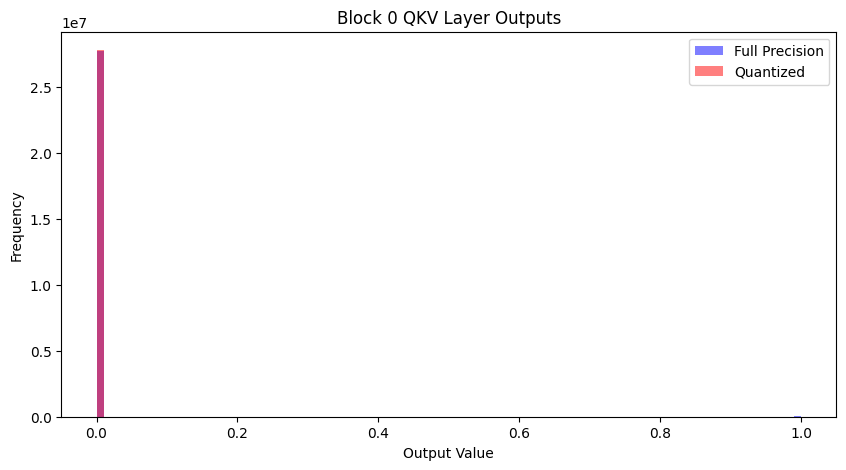

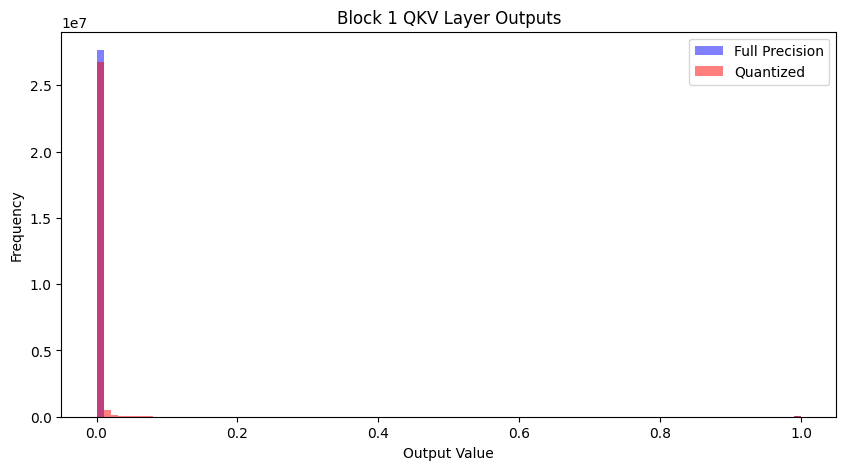

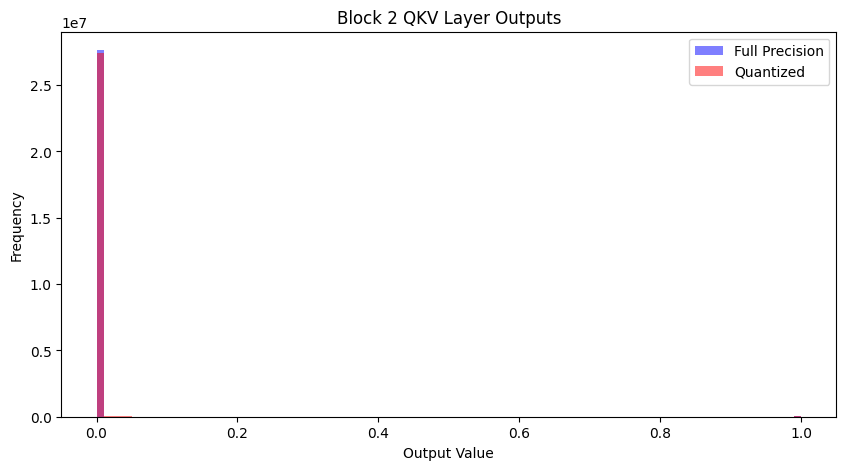

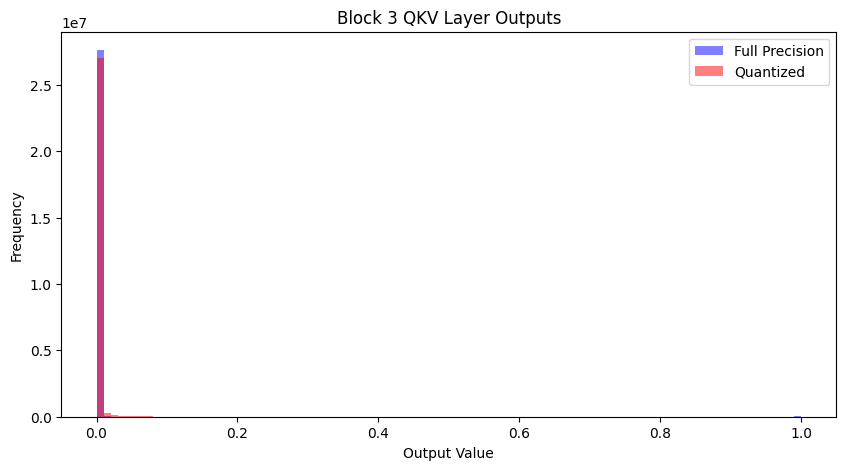

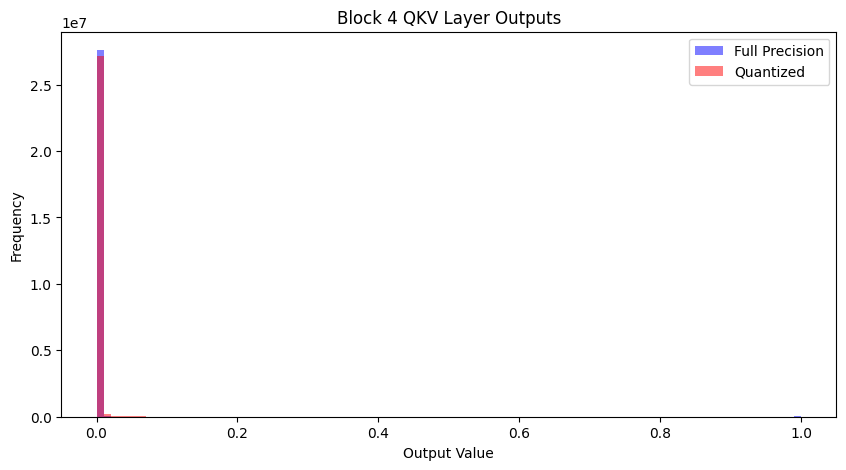

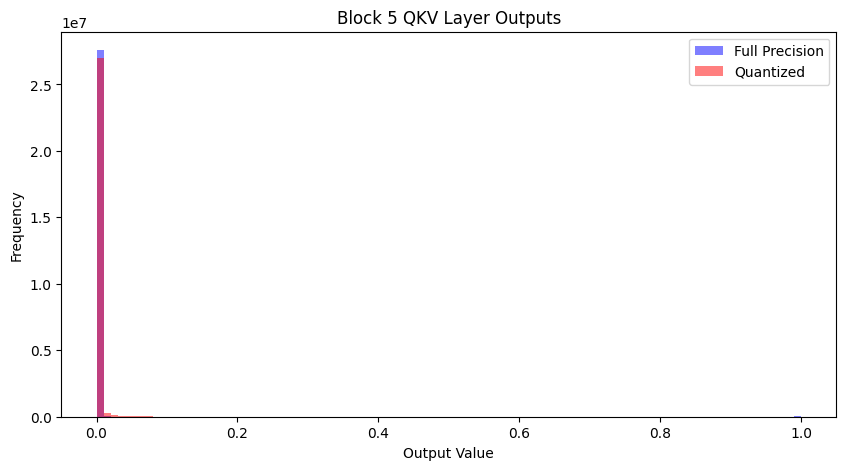

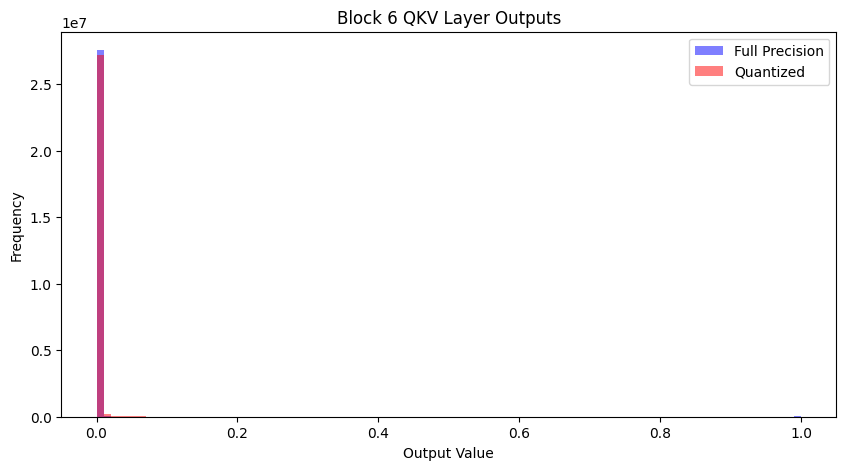

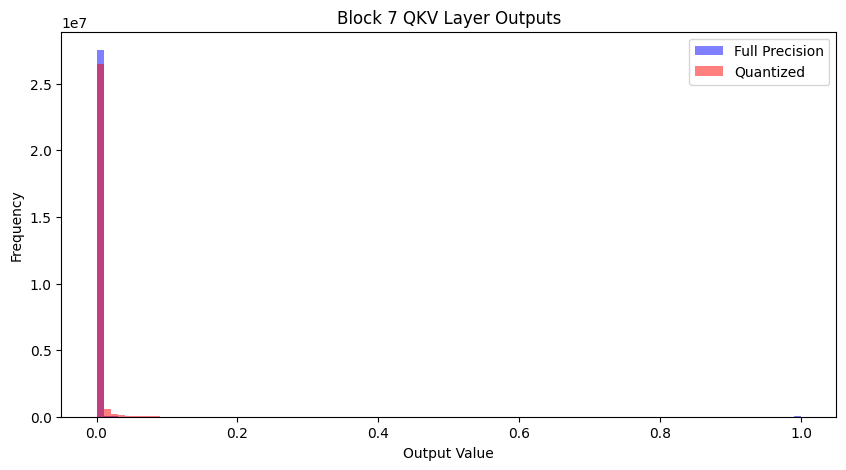

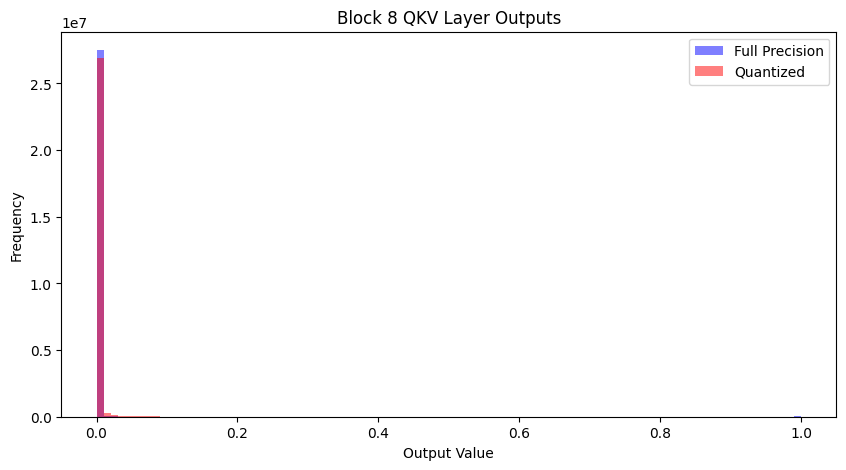

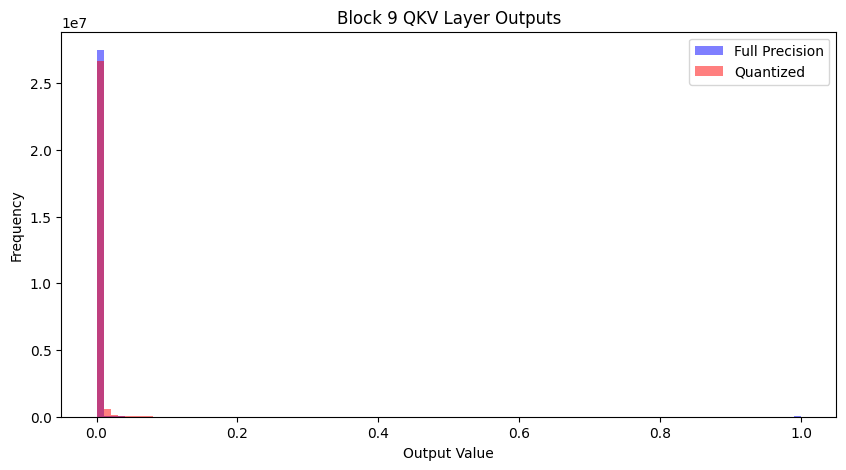

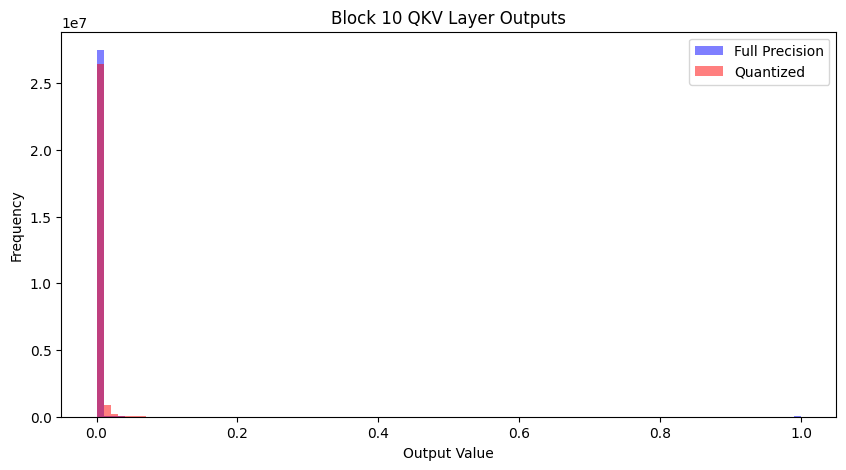

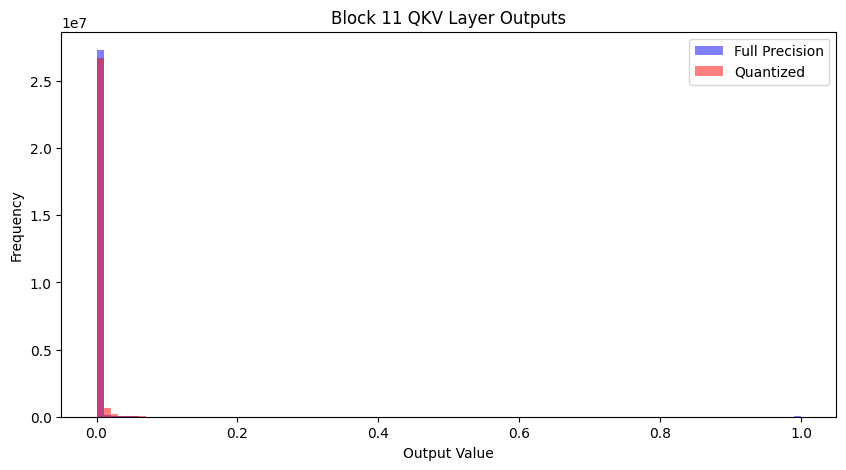

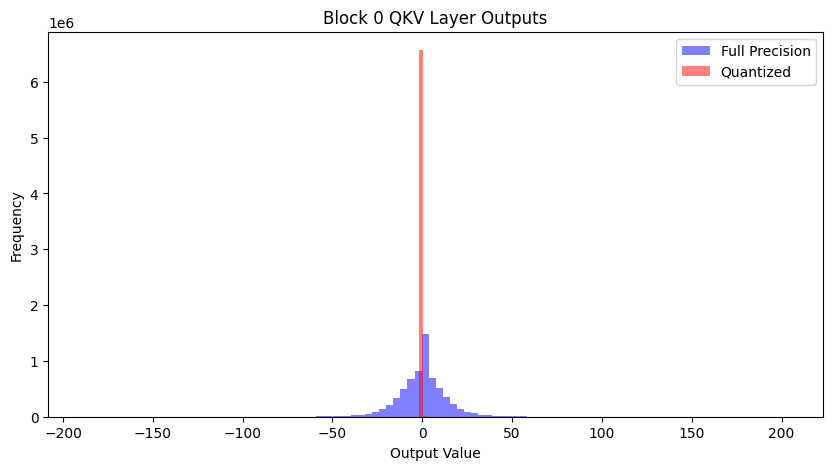

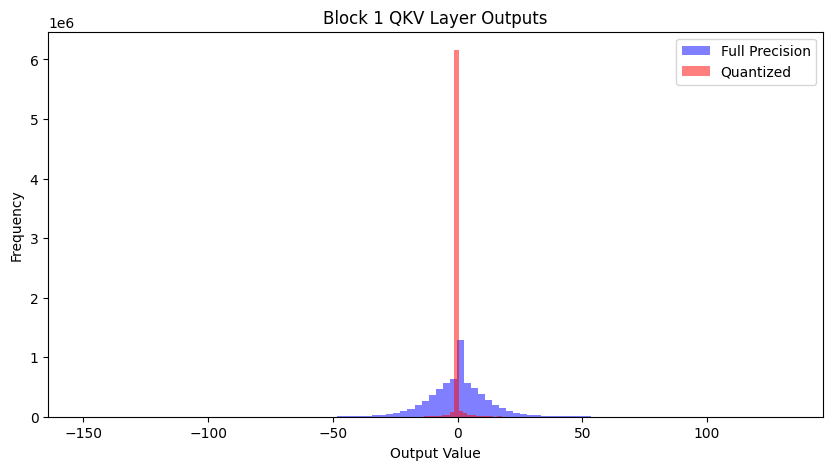

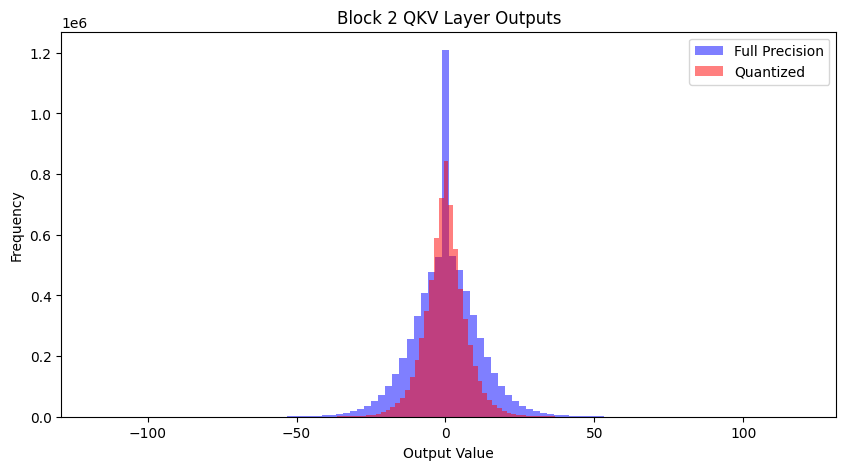

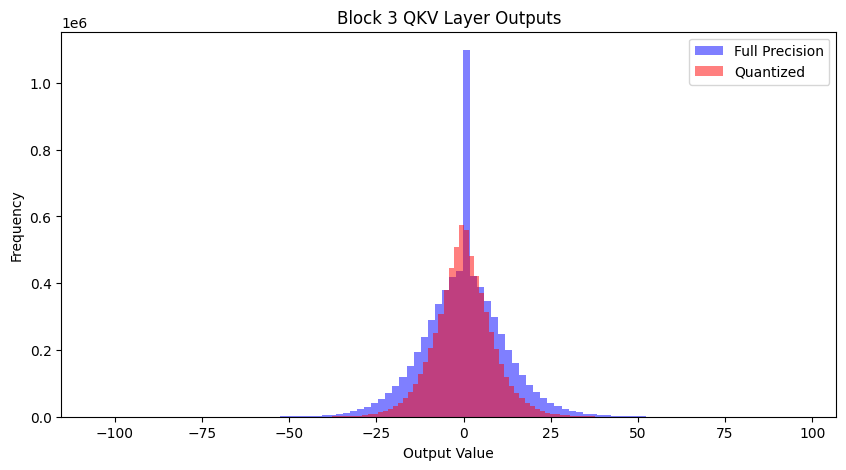

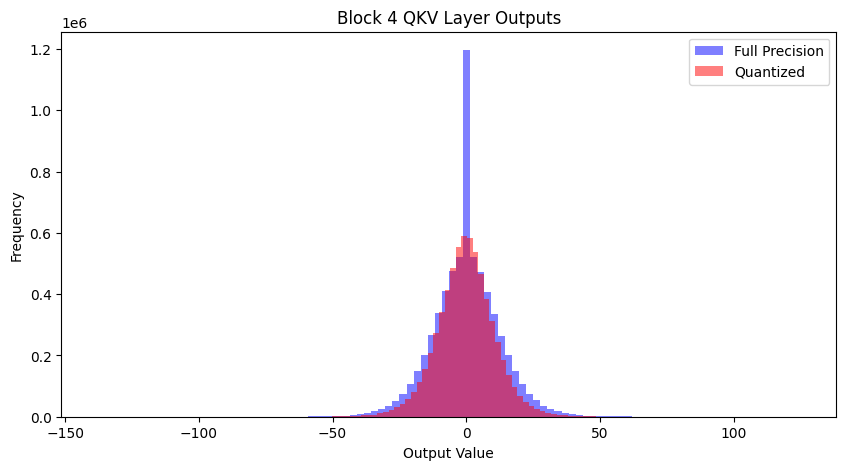

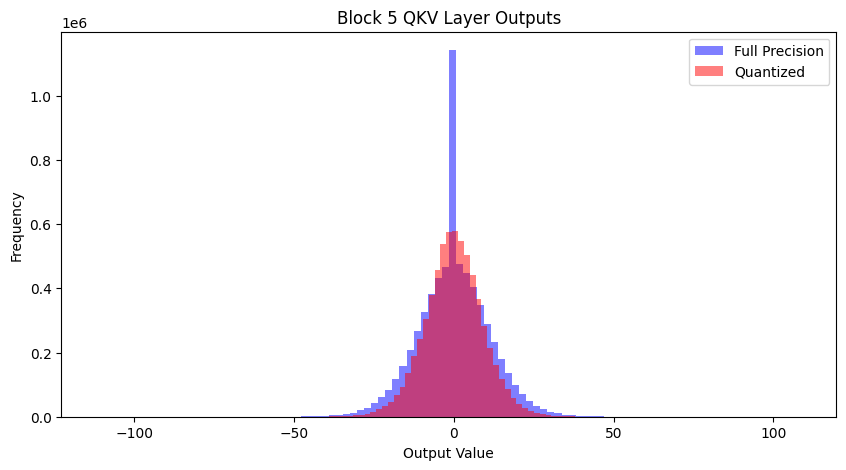

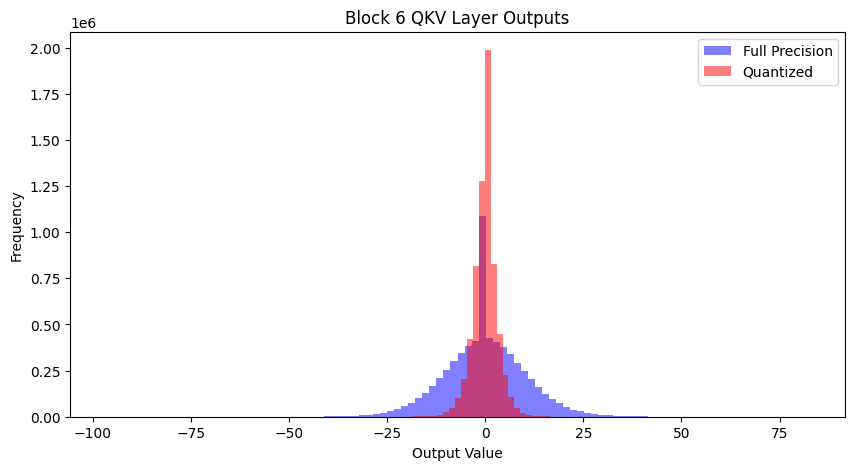

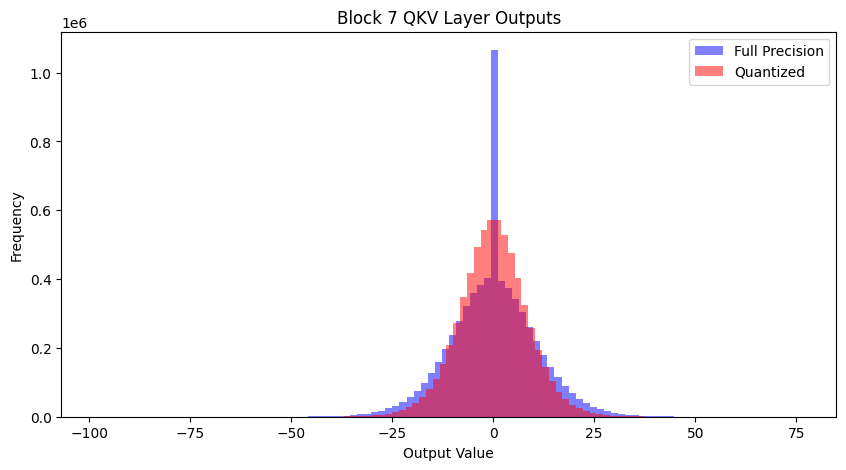

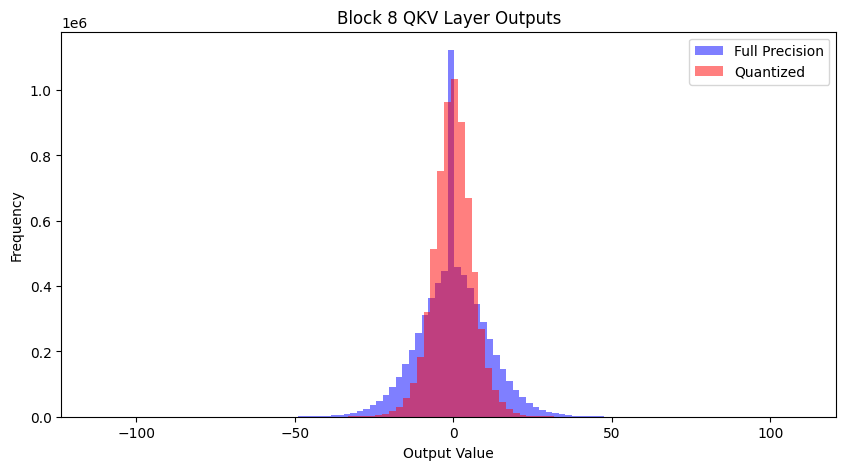

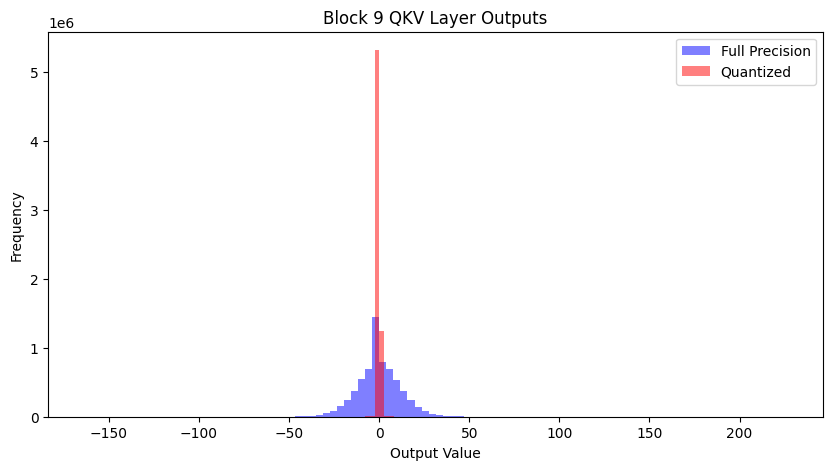

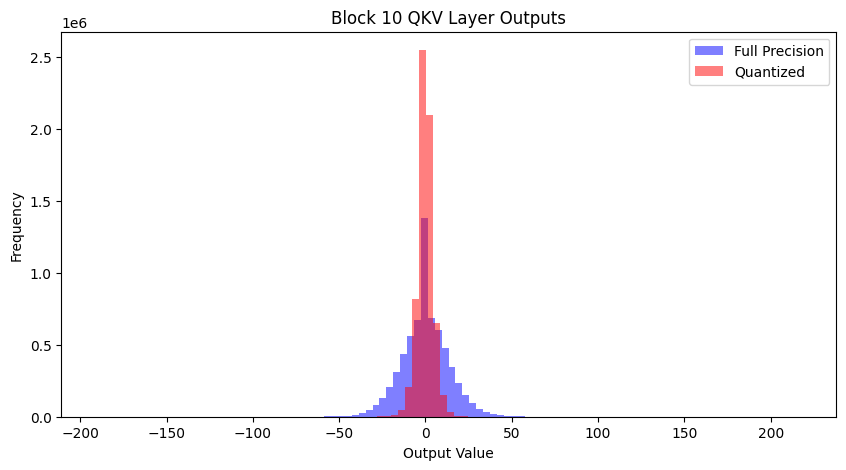

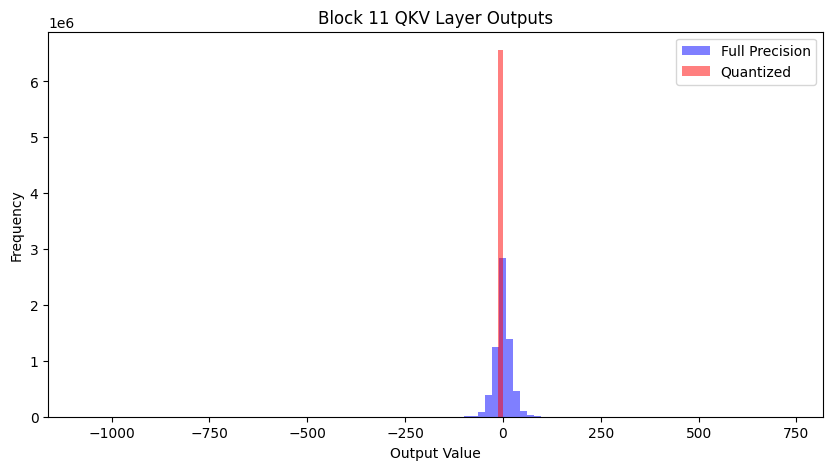

In [62]:
def compute_stats(full, quant):
    eps = 1e-6  # Prevent division by zero
    full_mean = full.mean().item()
    quant_mean = quant.mean().item()
    
    mean_change = abs(quant_mean - full_mean) / (abs(full_mean) + eps) * 100

    full_var = full.var().item()
    quant_var = quant.var().item()
    var_change = abs(quant_var - full_var) / (full_var + eps) * 100

    return {
        "mean_change": mean_change,
        "var_change": var_change
    }

def attention_kl(attn_full, attn_quant):
    # eps = 1e-8
    # return (attn_full * (torch.log(attn_full + eps) 
    #                    - torch.log(attn_quant + eps))).sum(-1).mean().item()
    eps = 1e-8
    # Ensure attn_full and attn_quant are tensors
    if not isinstance(attn_full, torch.Tensor):
        attn_full = torch.tensor(attn_full)
    if not isinstance(attn_quant, torch.Tensor):
        attn_quant = torch.tensor(attn_quant)
    return (attn_full * (torch.log(attn_full + eps) 
                       - torch.log(attn_quant + eps))).sum(-1).mean().item()


def head_importance_diff(full_attn, quant_attn):
    # Calculate how much each head's attention pattern changes
    head_diffs = []
    for h in range(full_attn.size(1)):  # Iterate over heads
        kl = attention_kl(full_attn[:,h], quant_attn[:,h])
        head_diffs.append(kl)
    return torch.std(torch.tensor(head_diffs)).item()  # Important if variance is high

def logit_sensitivity(logits_full, logits_quant, target):

    # Class probability changes for true labels
    prob_diff = F.softmax(logits_quant, 1)[range(len(target)), target] \
              - F.softmax(logits_full, 1)[range(len(target)), target]
    return prob_diff.mean().item()

def boundary_crossings(logits_full, logits_quant):
    with torch.no_grad():
        pred_full = torch.argmax(logits_full, 1)
        pred_quant = torch.argmax(logits_quant, 1)

    return (pred_full != pred_quant).float().mean().item()

def gradient_importance(model, batch, layer_name):
    model.zero_grad()
    infer1 = model.infer(
            batch, mask_text=False, mask_image=False, image_token_type_idx=1
        )
    infer2 = model.infer(
        batch, mask_text=False, mask_image=False, image_token_type_idx=2
    )
    cls_feats_full = torch.cat([infer1["cls_feats"], infer2["cls_feats"]], dim=-1)
    logits_full = model.nlvr2_classifier(cls_feats_full)

    nlvr2_labels = batch["answers"]
    target = torch.tensor(nlvr2_labels).to(model.device).long()
    
    loss = F.cross_entropy(logits_full, target)
    loss.backward()
    
    layer = dict(model.named_modules())[layer_name]
    grads = [p.grad.flatten() for p in layer.parameters()]
    return torch.cat(grads).norm().item()

def analyze_block_impact(full_model, quant_model, batch, target, block):
    metrics = {}

    with torch.no_grad():
        infer1 = full_model.infer(
            batch, mask_text=False, mask_image=False, image_token_type_idx=1
        )
        infer2 = full_model.infer(
            batch, mask_text=False, mask_image=False, image_token_type_idx=2
        )
        cls_feats_full = torch.cat([infer1["cls_feats"], infer2["cls_feats"]], dim=-1)
        logits_full = full_model.nlvr2_classifier(cls_feats_full)

        #
        #
        # Quantized model
        #
        #
        infer1 = quant_model.infer(
            batch, mask_text=False, mask_image=False, image_token_type_idx=1
        )
        infer2 = quant_model.infer(
            batch, mask_text=False, mask_image=False, image_token_type_idx=2
        )
        cls_feats_quant = torch.cat([infer1["cls_feats"], infer2["cls_feats"]], dim=-1)
        logits_quant = quant_model.nlvr2_classifier(cls_feats_quant)
    
    nlvr2_labels = batch["answers"]
    target = torch.tensor(nlvr2_labels).to(full_model.device).long()

    # Forward pass through full precision model
    with torch.no_grad():
        x, co_masks = model.get_co_embeds(batch)
        x_quant, co_masks_quant = quant_model.get_co_embeds(batch)

    with torch.no_grad():
        full_outputs = full_model.transformer.blocks[block].attn.modified_forward(x, co_masks)
        full_attn = full_outputs[1]  # Attention matrix
        full_qkv = full_outputs[2]   # qkv output
        full_proj = full_outputs[0]  # proj output

    # Forward pass through quantized model
    with torch.no_grad():
        quant_outputs = quant_model.transformer.blocks[block].attn.modified_forward(x_quant, co_masks_quant)
        quant_attn = quant_outputs[1]
        quant_qkv = quant_outputs[2]
        quant_proj = quant_outputs[0]
    
    # Attention metrics
    metrics['attn_kl'] = attention_kl(full_attn, quant_attn)
    metrics['head_std'] = head_importance_diff(full_attn, quant_attn)
    
    # Propagation metrics
    metrics['logit_sens'] = logit_sensitivity(logits_full, logits_quant, target)
    metrics['boundary_cross'] = boundary_crossings(logits_full, logits_quant)
    
    # Gradient importance
    metrics['grad_importance'] = gradient_importance(
        full_model, input_, f"transformer.blocks.{block}.attn"
    )
    
    return metrics

import matplotlib.pyplot as plt
import numpy as np

def plot_histograms(full_output, quant_output, title="Projection Layer Outputs"):
    plt.figure(figsize=(10, 5))
    plt.hist(full_output.flatten().cpu().numpy(), bins=100, alpha=0.5, label="Full Precision", color="blue")
    plt.hist(quant_output.flatten().cpu().numpy(), bins=100, alpha=0.5, label="Quantized", color="red")
    plt.title(title)
    plt.xlabel("Output Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

def infer_model(model, batch):
    with torch.no_grad():
        infer1 = model.infer(
            batch, mask_text=False, mask_image=False, image_token_type_idx=1
        )
        infer2 = model.infer(
            batch, mask_text=False, mask_image=False, image_token_type_idx=2
        )
        cls_feats = torch.cat([infer1["cls_feats"], infer2["cls_feats"]], dim=-1)
        logits = model.nlvr2_classifier(cls_feats)

    # Forward pass through full precision model
    with torch.no_grad():
        x, co_masks = model.get_co_embeds(input_)
        x_quant, co_masks_quant = model_dynamic.get_co_embeds(input_)

    with torch.no_grad():
        full_outputs = model.transformer.blocks[i].attn.modified_forward(x, co_masks)
        attn = full_outputs[1]  # Attention matrix
        qkv = full_outputs[2]   # qkv output
        proj = full_outputs[0]  # proj output
    
    return attn, qkv, proj, logits





for i in range(12):
    layer_to_quantize = f"transformer.blocks.{i}.attn.qkv"
    model_dynamic = deepcopy(model)
    torch.quantization.quantize_dynamic(
        model_dynamic, {layer_to_quantize: quantization_config}, inplace=True
    )
    
    full_outs = infer_model(model, input_)
    quant_outs = infer_model(model_dynamic, input_)
    plot_histograms(full_outs[0], quant_outs[0], title=f"Block {i} QKV Layer Outputs")

    # x, co_masks = model.get_co_embeds(input_, i)
    # x_quant, co_masks_quant = model_dynamic.get_co_embeds(input_, i)
    
    # with torch.no_grad():
    #     # Full-precision activations
    #     x_fc1_full = model.transformer.blocks[i].mlp.fc1(x)
    #     x_fc2_full = model.transformer.blocks[i].mlp.fc2(x_fc1_full)
        
    #     # Quantized activations
    #     x_fc1_quant = model_dynamic.transformer.blocks[i].mlp.fc1(x_quant)
    #     x_fc2_quant = model_dynamic.transformer.blocks[i].mlp.fc2(x_fc1_quant)

    # plot_histograms(x_fc2_full, x_fc2_quant, title=f"Block {i} QKV Layer Outputs")

    

    # block9_metrics = analyze_block_impact(model, model_dynamic, input_, input_['answers'], i)
    # print(f"Block {i} Attn, {block9_metrics['attn_kl']:.6f}, {block9_metrics['head_std']:.6f}, {block9_metrics['logit_sens']:.2f}, {block9_metrics['boundary_cross']:.2f}, {block9_metrics['grad_importance']:.6f}")
    # print(f"Attention KL: {block9_metrics['attn_kl']:.2f}")
    # print(f"Head Consistency: {block9_metrics['head_std']:.2f}")
    # print(f"Logit Sensitivity: {block9_metrics['logit_sens']:.2f}")
    # print(f"Boundary Crossings: {block9_metrics['boundary_cross']:.2f}")
    # print(f"Gradient Importance: {block9_metrics['grad_importance']:.2f}")

    
for i in range(12):
    layer_to_quantize = f"transformer.blocks.{i}.attn.proj"
    model_dynamic = deepcopy(model)
    torch.quantization.quantize_dynamic(
        model_dynamic, {layer_to_quantize: quantization_config}, inplace=True
    )

    full_outs = infer_model(model, input_)
    quant_outs = infer_model(model_dynamic, input_)
    plot_histograms(full_outs[2], quant_outs[2], title=f"Block {i} QKV Layer Outputs")

    # block9_metrics = analyze_block_impact(model, model_dynamic, input_, input_['answers'], i)
    # print(f"Block {i} Proj, {block9_metrics['attn_kl']:.6f}, {block9_metrics['head_std']:.6f}, {block9_metrics['logit_sens']:.2f}, {block9_metrics['boundary_cross']:.2f}, {block9_metrics['grad_importance']:.6f}")
    # print(f"Attention KL: {block9_metrics['attn_kl']:.2f}")
    # print(f"Head Consistency: {block9_metrics['head_std']:.2f}")
    # print(f"Logit Sensitivity: {block9_metrics['logit_sens']:.2f}")
    # print(f"Boundary Crossings: {block9_metrics['boundary_cross']:.2f}")
    # print(f"Gradient Importance: {block9_metrics['grad_importance']:.2f}")


    

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_weight_distributions(model, model_quant, block):
    """Plot weight distributions for fc1 and fc2 layers."""
    # Full-precision weights
    fc1_full = model.transformer.blocks[block].attn.qkv.weight.detach().flatten().cpu().numpy()
    # fc2_full = model.transformer.blocks[block].mlp.fc2.weight.detach().flatten().cpu().numpy()
    min_full, max_full = fc1_full.min(), fc1_full.max()
    
    # Quantized weights
    fc1_quant = model_quant.transformer.blocks[block].attn.qkv.weight().dequantize().detach().flatten().cpu().numpy()
    # fc2_quant = model_quant.transformer.blocks[block].mlp.fc2.weight().dequantize().detach().flatten().cpu().numpy()
    min_quant, max_quant = fc1_quant.min(), fc1_quant.max()
    
    # Plot fc1
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 1, 1)
    # sns.kdeplot(fc1_full, label='Full Precision', color='blue')
    # sns.kdeplot(fc1_quant, label='Quantized', color='red')
    plt.hist(fc1_full, bins=50, alpha=0.5, label='Full Precision', color='blue')
    plt.hist(fc1_quant, bins=50, alpha=0.5, label='Quantized', color='red')
    plt.title(f'Block {block} Attn.qkv Weight Distribution\n Mins: Full={min_full:.6f}, Quant={min_quant:.6f},\nMaxs: Full={max_full:.6f}, Quant={max_quant:.6f}')
    plt.xlabel('Weight Value')
    plt.legend()

    plt.xlim(-2, 2)
    plt.ylim(0,10)
    
    
    # # Plot fc2
    # plt.subplot(1, 2, 2)
    # # sns.kdeplot(fc2_full, label='Full Precision', color='blue')
    # # sns.kdeplot(fc2_quant, label='Quantized', color='red')
    # plt.hist(fc2_full, bins=10, alpha=0.5, label='Full Precision', color='blue')
    # plt.hist(fc2_quant, bins=10, alpha=0.5, label='Quantized', color='red')
    # plt.title(f'Block {block} MLP.fc2 Weight Distribution')
    # plt.xlabel('Weight Value')
    # plt.legend()

    # plt.xlim(-2, 2)
    # plt.ylim(0,10)
    
    
    plt.tight_layout()
    plt.show()

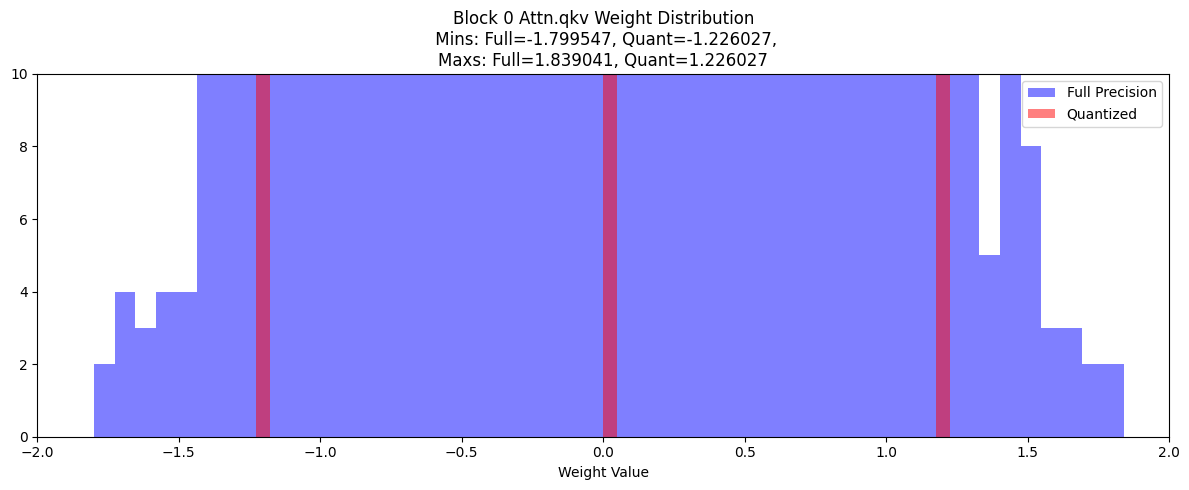

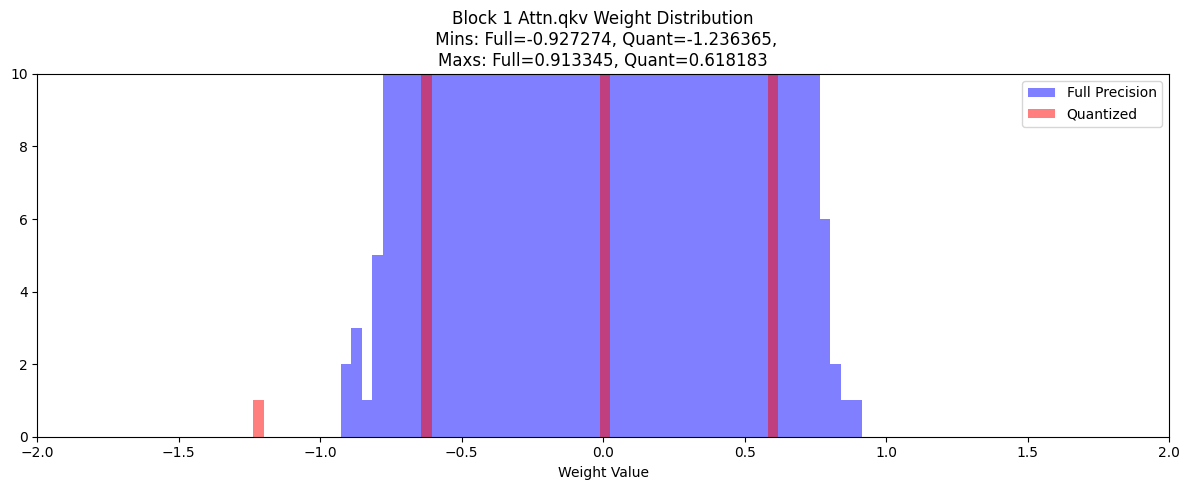

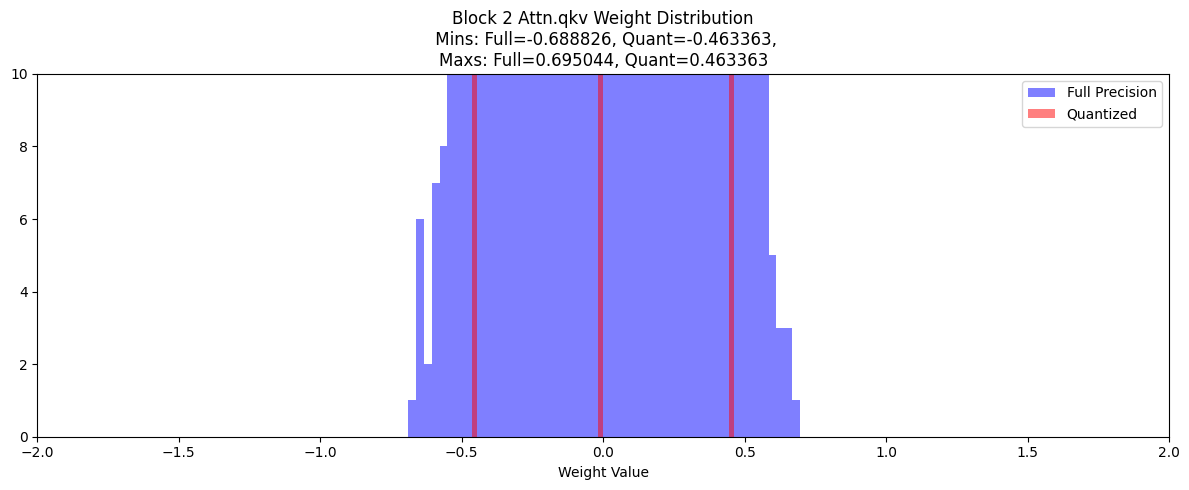

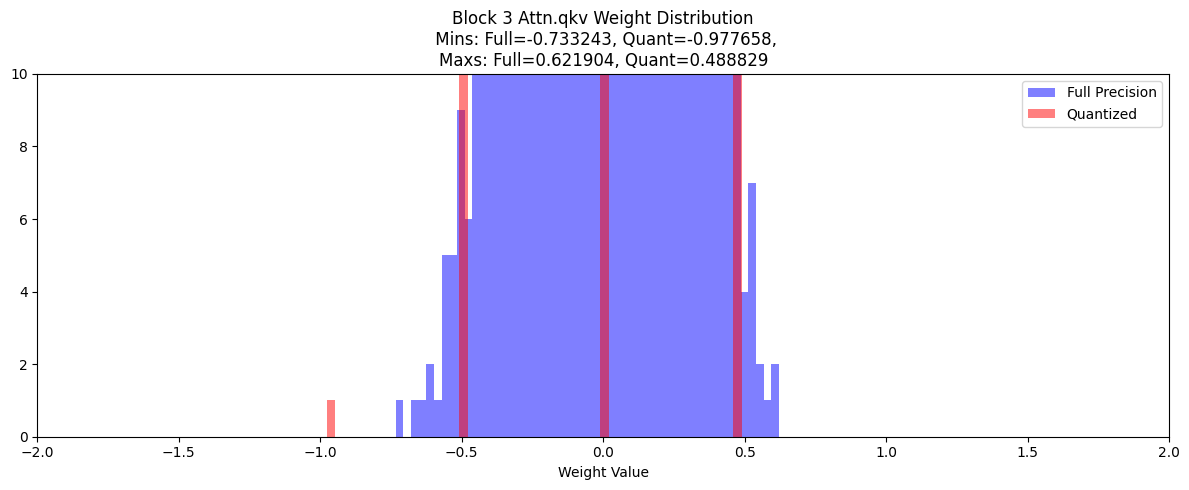

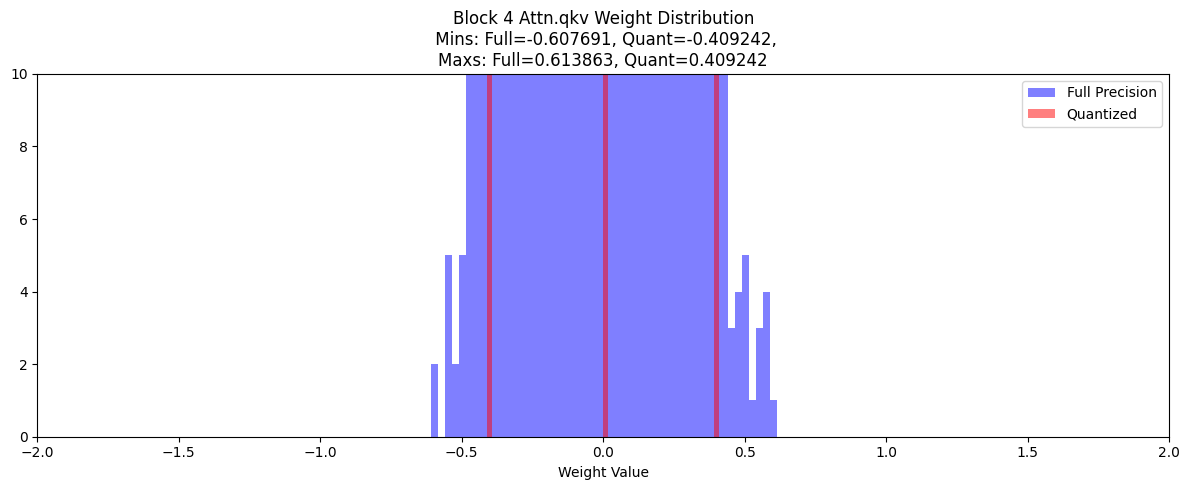

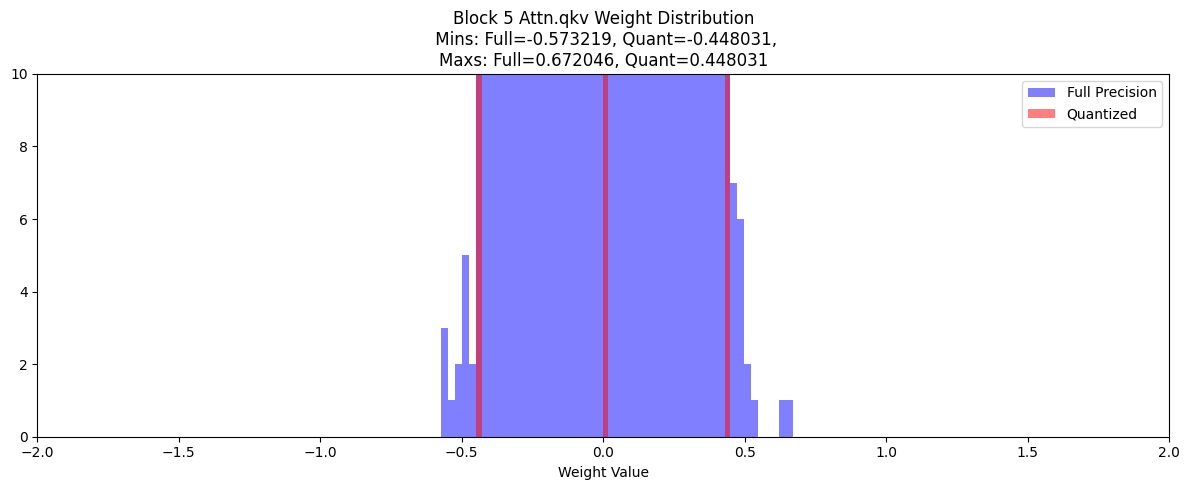

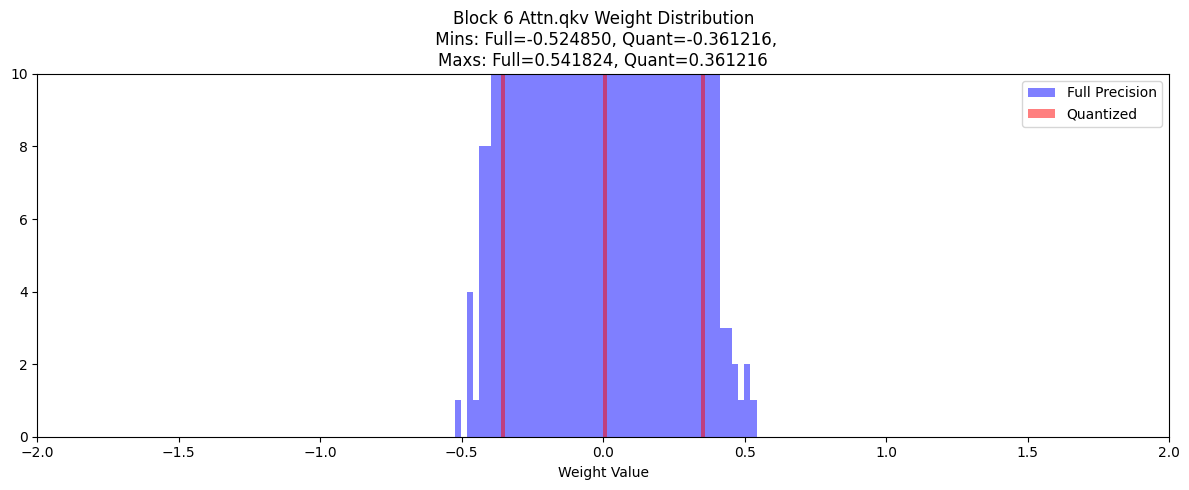

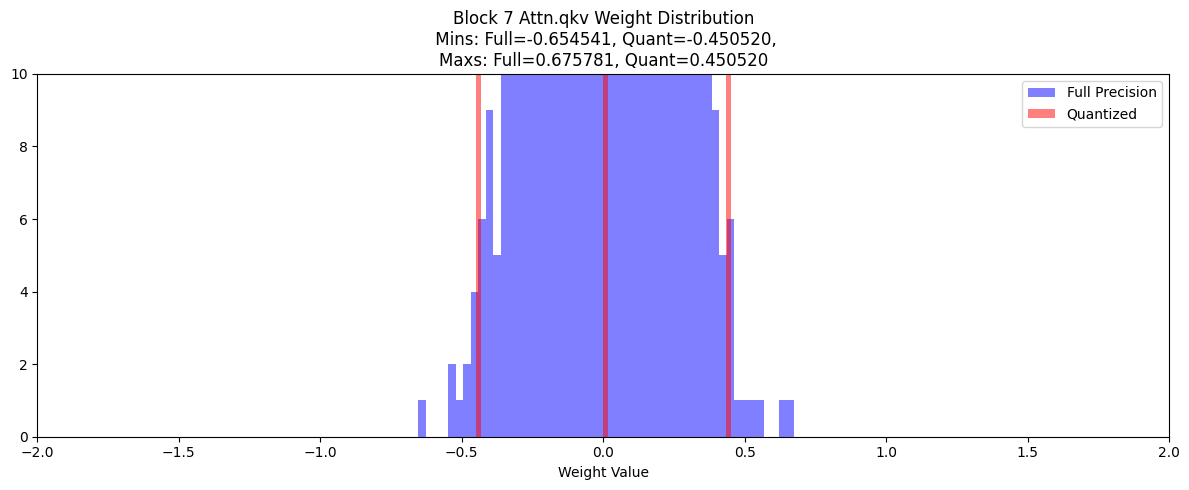

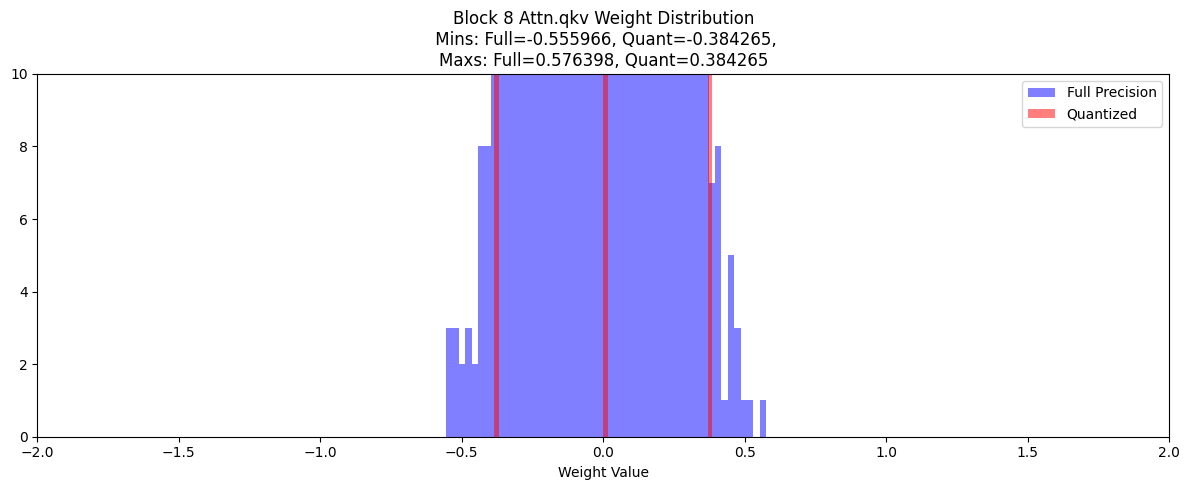

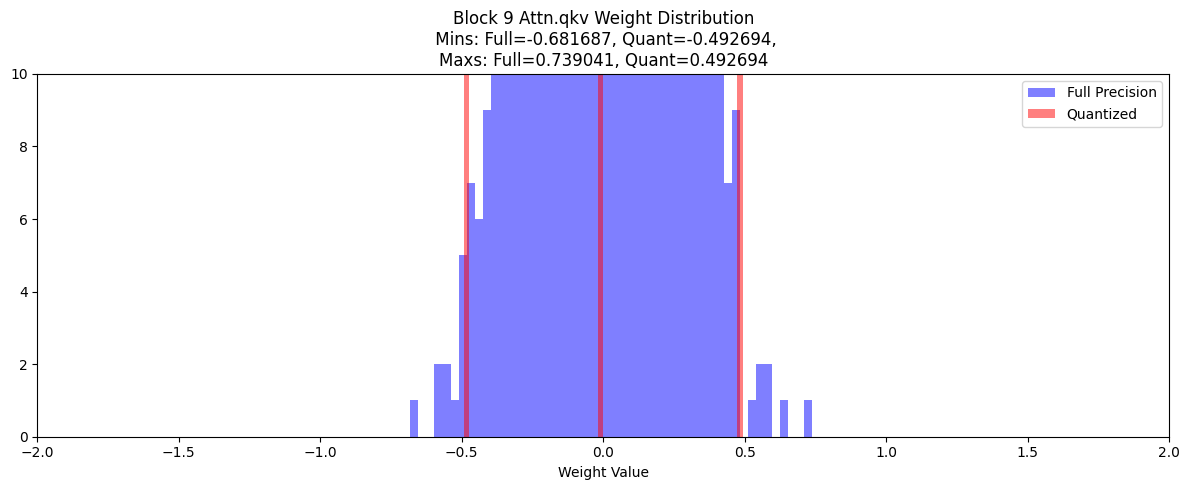

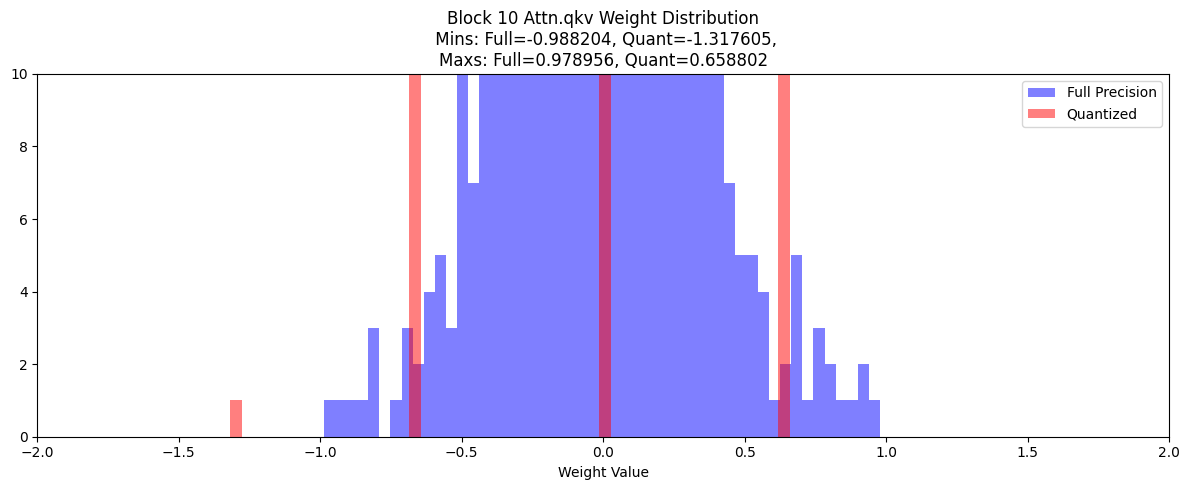

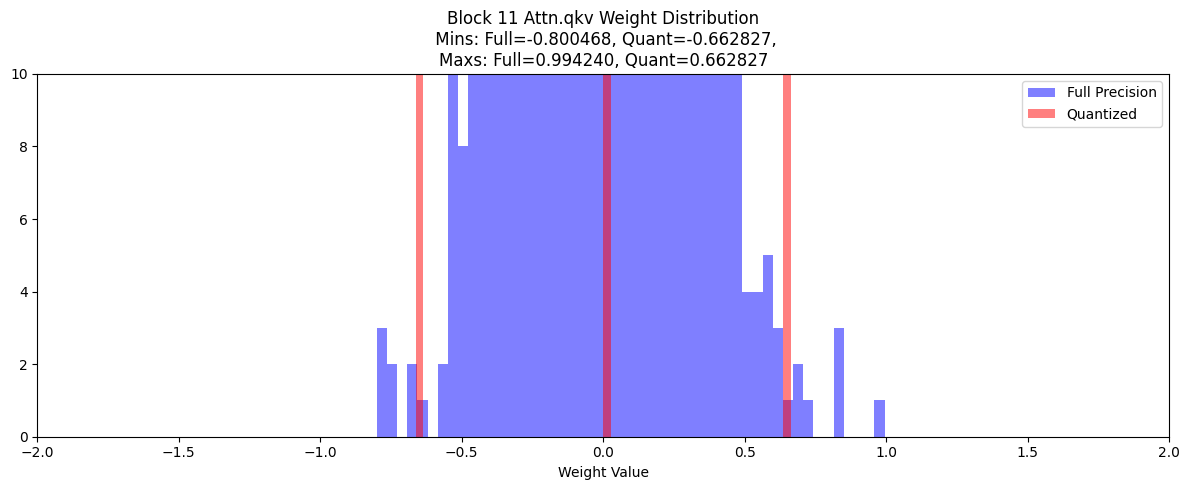

In [24]:
for i in range(12):

    # Quantize MLP layers (fc1 and fc2)
    layer_to_quantize = f"transformer.blocks.{i}.attn"
    model_dynamic = deepcopy(model)
    torch.quantization.quantize_dynamic(
        model_dynamic, {layer_to_quantize: quantization_config}, inplace=True
    )

    plot_weight_distributions(model, model_dynamic, block=i)

In [8]:
def plot_weight_distributions(model_full, model_quant, block_id):

    """Plot weight distributions for fc1 and fc2 layers."""
    # Full-precision weights
    module_full = get_module_by_path(model_full, module).weight.detach().flatten().cpu().numpy()
    module_quant = get_module_by_path(model_quant, module).weight().detach().dequantize().flatten().cpu().numpy()
    
    # Plot fc1
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    sns.kdeplot(module_full, label='Full Precision', color='blue')
    sns.kdeplot(module_quant, label='Quantized', color='red')
    plt.title(f'Module {module} Weight Distribution')
    plt.xlabel('Weight Value')
    plt.legend()

    plt.subplot(1, 3, 2)
    sns.kdeplot(module_full, label='Full Precision', color='blue')
    sns.kdeplot(module_quant, label='Quantized', color='red')
    plt.title(f'Module {module} Weight Distribution')
    plt.xlabel('Weight Value')
    plt.legend()

    plt.subplot(1, 3, 3)
    sns.kdeplot(module_full, label='Full Precision', color='blue')
    sns.kdeplot(module_quant, label='Quantized', color='red')
    plt.title(f'Module {module} Weight Distribution')
    plt.xlabel('Weight Value')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

module_path = "transformer.blocks.0.mlp.fc1"
plot_weight_distributions(model, model_dynamic, module_path)

In [16]:
def plot_weight_distributions(model_full, model_quant, name):

    """Plot weight distributions for fc1 and fc2 layers."""
    # Full-precision weights
    qkv_full = get_module_by_path(model_full, name + ".attn.qkv").weight.detach().flatten().cpu().numpy()
    qkv_quant = get_module_by_path(model_quant, name + ".attn.qkv").weight().detach().dequantize().flatten().cpu().numpy()

    fc1_full = get_module_by_path(model_full, name + ".mlp.fc1").weight.detach().flatten().cpu().numpy()
    fc2_full = get_module_by_path(model_full, name + ".mlp.fc2").weight.detach().flatten().cpu().numpy()

    fc1_quant = get_module_by_path(model_quant, name + ".mlp.fc1").weight().detach().dequantize().flatten().cpu().numpy()
    fc2_quant = get_module_by_path(model_quant, name + ".mlp.fc2").weight().detach().dequantize().flatten().cpu().numpy()
    
    # Plot fc1
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    sns.kdeplot(qkv_full, label='Full Precision', color='blue')
    sns.kdeplot(qkv_quant, label='Quantized', color='red')
    plt.title(f'Weight Distribution \nModule {name}.attn.qkv')
    plt.xlabel('Weight Value')
    plt.legend()

    plt.subplot(1, 3, 2)
    sns.kdeplot(fc1_full, label='Full Precision', color='blue')
    sns.kdeplot(fc1_quant, label='Quantized', color='red')
    plt.title(f'Weight Distribution \nModule {name}.mlp.fc1')
    plt.xlabel('Weight Value')
    plt.legend()

    plt.subplot(1, 3, 3)
    sns.kdeplot(fc2_full, label='Full Precision', color='blue')
    sns.kdeplot(fc2_quant, label='Quantized', color='red')
    plt.title(f'Weight Distribution \nModule {name}.mlp.fc2')
    plt.xlabel('Weight Value')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [10]:
# layer_name = "transformer.blocks."
# for i in range(12):
#     layer_name = layer_name + str(i)
#     plot_weight_distributions(model, model_dynamic, layer_name)

In [11]:
import numpy as np
import torch.nn.functional as F

def analyze_mlp_activations(model, model_quant, batch, block):
    """Compare activations of MLP layers (fc1 and fc2) for a specific block."""
    x, co_masks = model.get_co_embeds(batch)
    x_quant, co_masks_quant = model_quant.get_co_embeds(batch)
    
    with torch.no_grad():
        # Full-precision activations
        x_fc1_full = model.transformer.blocks[block].mlp.fc1(x)
        x_fc2_full = model.transformer.blocks[block].mlp.fc2(x_fc1_full)
        
        # Quantized activations
        x_fc1_quant = model_quant.transformer.blocks[block].mlp.fc1(x_quant)
        x_fc2_quant = model_quant.transformer.blocks[block].mlp.fc2(x_fc1_quant)
    
    # Compute metrics for fc1
    mse_fc1 = F.mse_loss(x_fc1_full, x_fc1_quant).item()
    cosine_fc1 = F.cosine_similarity(x_fc1_full.flatten(), x_fc1_quant.flatten(), dim=0).item()
    
    # Compute metrics for fc2
    mse_fc2 = F.mse_loss(x_fc2_full, x_fc2_quant).item()
    cosine_fc2 = F.cosine_similarity(x_fc2_full.flatten(), x_fc2_quant.flatten(), dim=0).item()
    
    # Activation statistics (mean and variance)
    stats = {
        'fc1_full_mean': x_fc1_full.mean().item(),
        'fc1_full_var': x_fc1_full.var().item(),
        'fc1_quant_mean': x_fc1_quant.mean().item(),
        'fc1_quant_var': x_fc1_quant.var().item(),
        'fc2_full_mean': x_fc2_full.mean().item(),
        'fc2_full_var': x_fc2_full.var().item(),
        'fc2_quant_mean': x_fc2_quant.mean().item(),
        'fc2_quant_var': x_fc2_quant.var().item(),
    }
    
    return {
        'mse_fc1': mse_fc1,
        'cosine_fc1': cosine_fc1,
        'mse_fc2': mse_fc2,
        'cosine_fc2': cosine_fc2,
        'stats': stats
    }


dict_keys(['answers', 'image_1', 'text', 'image_0', 'table_name', 'text_ids', 'text_labels', 'text_ids_mlm', 'text_labels_mlm', 'text_masks'])
Number of batches: 1
Smaples in a batch: 5


In [13]:
# Compare activations
for i in range(12):
    mlp_metrics = analyze_mlp_activations(model, model_dynamic, batch=input_, block=i)
    print(f"Block {i} MLP Metrics:")
    print(f"  FC1: MSE={mlp_metrics['mse_fc1']:.4f}, Cosine={mlp_metrics['cosine_fc1']:.4f}")
    print(f"  FC2: MSE={mlp_metrics['mse_fc2']:.4f}, Cosine={mlp_metrics['cosine_fc2']:.4f}")
    print("  Activation Stats:")
    print(f"    FC1 Mean: Full={mlp_metrics['stats']['fc1_full_mean']:.4f}, Quant={mlp_metrics['stats']['fc1_quant_mean']:.4f}")
    print(f"    FC1 Var: Full={mlp_metrics['stats']['fc1_full_var']:.4f}, Quant={mlp_metrics['stats']['fc1_quant_var']:.4f}")
    print(f"    FC2 Mean: Full={mlp_metrics['stats']['fc2_full_mean']:.4f}, Quant={mlp_metrics['stats']['fc2_quant_mean']:.4f}")
    print(f"    FC2 Var: Full={mlp_metrics['stats']['fc2_full_var']:.4f}, Quant={mlp_metrics['stats']['fc2_quant_var']:.4f}")

Block 0 MLP Metrics:
  FC1: MSE=11.2935, Cosine=0.8809
  FC2: MSE=2144.3992, Cosine=0.5371
  Activation Stats:
    FC1 Mean: Full=-1.2116, Quant=-1.0015
    FC1 Var: Full=47.3903, Quant=44.1537
    FC2 Mean: Full=0.5933, Quant=0.4348
    FC2 Var: Full=2968.9297, Quant=559.3957


/data-4/users/mileriso/envs/.dev/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Block 1 MLP Metrics:
  FC1: MSE=8.7818, Cosine=0.8754
  FC2: MSE=744.0986, Cosine=0.3749
  Activation Stats:
    FC1 Mean: Full=-1.7641, Quant=-1.4418
    FC1 Var: Full=32.5487, Quant=32.4708
    FC2 Mean: Full=-0.1322, Quant=0.0874
    FC2 Var: Full=861.3378, Quant=81.9081
Block 2 MLP Metrics:
  FC1: MSE=4.8194, Cosine=0.8996
  FC2: MSE=438.6068, Cosine=0.2311
  Activation Stats:
    FC1 Mean: Full=-1.4619, Quant=-1.4367
    FC1 Var: Full=21.5704, Quant=22.0909
    FC2 Mean: Full=0.1099, Quant=0.0740
    FC2 Var: Full=463.3311, Quant=23.8571
Block 3 MLP Metrics:
  FC1: MSE=4.6765, Cosine=0.8665
  FC2: MSE=128.2267, Cosine=0.8208
  Activation Stats:
    FC1 Mean: Full=-1.2914, Quant=-1.2914
    FC1 Var: Full=15.3927, Quant=16.1861
    FC2 Mean: Full=0.0533, Quant=0.1208
    FC2 Var: Full=325.9565, Quant=379.9269
Block 4 MLP Metrics:
  FC1: MSE=4.6680, Cosine=0.8469
  FC2: MSE=184.6339, Cosine=0.7622
  Activation Stats:
    FC1 Mean: Full=-1.3528, Quant=-1.3225
    FC1 Var: Full=12.9400

In [15]:
print(attn_full.keys())
attn_full[f'block_{0}'].shape

dict_keys(['block_0', 'block_1', 'block_2', 'block_3', 'block_4', 'block_5', 'block_6', 'block_7', 'block_8', 'block_9', 'block_10', 'block_11'])


torch.Size([5, 12, 269, 269])

In [16]:
def plot_attention(attn_full, attn_quant, block=0, head=0, sample=0):
    """Visualize attention maps for a specific block and head."""
    plt.figure(figsize=(15, 5))
    
    # Full precision
    plt.subplot(1, 3, 1)
    attn = attn_full[f'block_{block}'][sample, head].cpu().numpy()
    plt.imshow(attn, cmap='viridis')
    plt.title(f'Full Precision (Block {block}, Head {head})')
    plt.colorbar()

    # Quantized
    plt.subplot(1, 3, 2)
    attn_q = attn_quant[f'block_{block}'][sample, head].cpu().numpy()
    plt.imshow(attn_q, cmap='viridis')
    plt.title(f'Quantized (Block {block}, Head {head})')
    plt.colorbar()

    # Difference
    plt.subplot(1, 3, 3)
    attn_diff = attn - attn_q
    plt.imshow(attn_diff, cmap='viridis')
    plt.title(f'Difference (Block {block}, Head {head})')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_activation_distributions(model, model_dynamic, input_, block):
    """Plot activation distributions for a specific block."""
    x, co_masks = model.get_co_embeds(input_)
    x_quant, co_masks_quant = model_dynamic.get_co_embeds(input_)
    
    with torch.no_grad():
        # Forward pass through full-precision model
        outputs_full, _ = model.transformer.blocks[block](x, mask=co_masks)
        # Forward pass through quantized model
        outputs_quant, _ = model_dynamic.transformer.blocks[block](x_quant, mask=co_masks_quant)
    
    # Flatten activations
    activations_full = outputs_full.flatten().cpu().numpy()
    activations_quant = outputs_quant.flatten().cpu().numpy()
    
    # Plot histograms
    plt.figure(figsize=(10, 5))
    sns.kdeplot(activations_full, label='Full Precision', color='blue')
    sns.kdeplot(activations_quant, label='Quantized', color='red')
    plt.title(f'Activation Distribution (Block {block})')
    plt.xlabel('Activation Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [18]:
from scipy.stats import entropy
import torch.nn.functional as F

def alignment_metrics(attn_full, attn_quant):
    """Compute metrics for all blocks and heads."""
    metrics = {'kl': [], 'cosine': []}
    for i in range(12):
        a_full = attn_full[f'block_{i}'].mean(1)  # Avg over heads
        a_quant = attn_quant[f'block_{i}'].mean(1)
        
        # KL divergence
        kl = entropy(a_full.flatten().cpu().numpy(), a_quant.flatten().cpu().numpy())
        metrics['kl'].append(kl)
        
        # Cosine similarity
        cosine = F.cosine_similarity(
            a_full.flatten().unsqueeze(0), a_quant.flatten().unsqueeze(0)
        ).item()
        metrics['cosine'].append(cosine)
    
    return metrics

In [19]:
def feature_mse(model, model_dynamic, input_, block):
    """Compute MSE between full-precision and quantized features for a specific block."""
    x, co_masks = model.get_co_embeds(input_)
    x_quant, co_masks_quant = model_dynamic.get_co_embeds(input_)
    
    with torch.no_grad():
        # Forward pass through full-precision model
        outputs_full, _ = model.transformer.blocks[block](x, mask=co_masks)
        # Forward pass through quantized model
        outputs_quant, _ = model_dynamic.transformer.blocks[block](x_quant, mask=co_masks_quant)
    
    # Compute MSE
    mse = F.mse_loss(outputs_full, outputs_quant).item()
    return mse

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_activation_distributions(model, model_dynamic, input_, block):
    """Plot activation distributions for a specific block."""
    x, co_masks = model.get_co_embeds(input_)
    x_quant, co_masks_quant = model_dynamic.get_co_embeds(input_)
    
    with torch.no_grad():
        # Forward pass through full-precision model
        outputs_full, _ = model.transformer.blocks[block](x, mask=co_masks)
        # Forward pass through quantized model
        outputs_quant, _ = model_dynamic.transformer.blocks[block](x_quant, mask=co_masks_quant)
    
    # Flatten activations
    activations_full = outputs_full.flatten().cpu().numpy()
    activations_quant = outputs_quant.flatten().cpu().numpy()
    
    # Plot histograms
    plt.figure(figsize=(10, 5))
    sns.kdeplot(activations_full, label='Full Precision', color='blue')
    sns.kdeplot(activations_quant, label='Quantized', color='red')
    plt.title(f'Activation Distribution (Block {block})')
    plt.xlabel('Activation Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def plot_activation_distributions(model, model_dynamic, input_, block):
    """Plot activation distributions for a specific block."""
    x, co_masks = model.get_co_embeds(input_)
    x_quant, co_masks_quant = model_dynamic.get_co_embeds(input_)
    
    with torch.no_grad():
        # Forward pass through full-precision model
        outputs_full, _ = model.transformer.blocks[block](x, mask=co_masks)
        # Forward pass through quantized model
        outputs_quant, _ = model_dynamic.transformer.blocks[block](x_quant, mask=co_masks_quant)
    
    # Flatten activations
    activations_full = outputs_full.flatten().cpu().numpy()
    activations_quant = outputs_quant.flatten().cpu().numpy()
    
    # Plot histograms
    plt.figure(figsize=(10, 5))
    sns.kdeplot(activations_full, label='Full Precision', color='blue')
    sns.kdeplot(activations_quant, label='Quantized', color='red')
    plt.title(f'Activation Distribution (Block {block})')
    plt.xlabel('Activation Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def plot_activation_distributions(model, model_quant, batch, i):
    """Plot activation distributions for each block."""
    with torch.no_grad():
        x_full, co_masks_full = model.get_co_embeds(batch)
        x_quant, co_masks_quant = model_quant.get_co_embeds(batch)


    with torch.no_grad():
        # Extract activations from full-precision model
        activations_full = model.transformer.blocks[i].attn.qkv(x_full).flatten().cpu().numpy()
        # Extract activations from quantized model
        activations_quant = model_quant.transformer.blocks[i].attn.qkv(x_quant).flatten().cpu().numpy()
    
    # Plot histograms
    plt.figure(figsize=(10, 5))
    sns.kdeplot(activations_full, label='Full Precision', color='blue')
    sns.kdeplot(activations_quant, label='Quantized', color='red')
    plt.title(f'Activation Distribution (Block {i})')
    plt.xlabel('Activation Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [21]:
from copy import deepcopy

precision = 4
print(f"Initializing the quantizers using precision: {precision}")
quantization_config, embedding_layer_qconfig = get_quantization_config(precision=precision)
print("Quantization config initialized")

# ========== Quantization ==========
# Get the names of the modules
names, _ = zip(*list(model.named_modules()))

# Get attention maps for the full-precision model
attn_full = get_attention_maps(model, input_)

for i in range(12):
    print(f"Block {i}")

    layer_to_quantize = "transformer.blocks." + str(i) + ".attn"

    # Check if the layer to quantize is in the model
    assert layer_to_quantize in names, f"Layer {layer_to_quantize} not found in the model"

    if "embeddings" in layer_to_quantize:
        quantization_config = embedding_layer_qconfig

    model_dynamic = deepcopy(model)
    
    torch.quantization.quantize_dynamic(
        model_dynamic, {layer_to_quantize: quantization_config}, inplace=True
    )
    
    # Plot activation distributions
    # plot_activation_distributions(model, model_dynamic, input_, i)

    # Get attention maps for the quantized model
    attn_quant = get_attention_maps(model_dynamic, input_)

    # Compute alignment metrics
    metrics = alignment_metrics(attn_full, attn_quant)

    # Print results
    print("Block\tKL Divergence\tCosine Similarity")
    print(f"{i}\t{metrics['kl'][i]:.4f}\t\t{metrics['cosine'][i]:.4f}")

    # Compute feature MSE
    mse_values = feature_mse(model, model_dynamic, input_, i)
    print(f"MSE:\t{mse_values}")

Initializing the quantizers using precision: 4
Quantization config initialized
Block 0
Block	KL Divergence	Cosine Similarity
0	0.0997		0.9732
MSE:	1.1548523902893066
Block 1
Block	KL Divergence	Cosine Similarity
1	0.1719		0.9696
MSE:	1.0241814851760864
Block 2
Block	KL Divergence	Cosine Similarity
2	0.2710		0.9293
MSE:	0.951977014541626
Block 3
Block	KL Divergence	Cosine Similarity
3	0.2573		0.9422
MSE:	1.0206326246261597
Block 4
Block	KL Divergence	Cosine Similarity
4	0.1895		0.9404
MSE:	1.003360390663147
Block 5
Block	KL Divergence	Cosine Similarity
5	0.2344		0.9200
MSE:	1.0049408674240112
Block 6
Block	KL Divergence	Cosine Similarity
6	0.2648		0.9142
MSE:	1.1942387819290161
Block 7
Block	KL Divergence	Cosine Similarity
7	0.4140		0.8536
MSE:	3.3333253860473633
Block 8
Block	KL Divergence	Cosine Similarity
8	0.6078		0.7523
MSE:	2.844006299972534
Block 9
Block	KL Divergence	Cosine Similarity
9	0.9683		0.6243
MSE:	3.7438392639160156
Block 10
Block	KL Divergence	Cosine Similarity
10	1.26

In [24]:
def kl_divergence(p, q):
    """Compute KL divergence between two distributions."""
    p = p.numpy().flatten() + 1e-10
    q = q.numpy().flatten() + 1e-10
    return entropy(p, q)

def alignment_metrics(attn_full, attn_quant):
    """Compute metrics for all blocks and heads."""
    metrics = {'kl': [], 'cosine': []}
    for block in range(12):
        a_full = attn_full[f'block_{block}'].mean(1)  # Avg over heads
        a_quant = attn_quant[f'block_{block}'].mean(1)
        
        # KL divergence
        kl = kl_divergence(a_full, a_quant)
        metrics['kl'].append(kl)
        
        # Cosine similarity
        cosine = torch.nn.functional.cosine_similarity(
            a_full.flatten(), a_quant.flatten(), dim=0
        ).item()
        metrics['cosine'].append(cosine)
    
    return metrics

def infer_transformer(model, batch, i):
    x, co_masks = model.get_co_embeds(batch)

    with torch.no_grad():
        # Forward pass through full-precision model
        outputs, _ = model.transformer.blocks[i](x, mask=co_masks)
    
    return outputs

def feature_mse(model, model_quant, batch, i):
    mse_values = []

    # Forward pass through full-precision model
    outputs_full = infer_transformer(model, batch, i)

    # Forward pass through quantized model
    outputs_quant = infer_transformer(model_quant, batch, i)
    
    # Compute MSE
    mse = torch.nn.functional.mse_loss(outputs_full, outputs_quant).item()
    mse_values.append(mse)
    return mse_values

import matplotlib.pyplot as plt
import seaborn as sns

def plot_activation_distributions(model, model_quant, batch, i):
    """Plot activation distributions for each block."""
    with torch.no_grad():
        x_full, co_masks_full = model.get_co_embeds(batch)
        x_quant, co_masks_quant = model_quant.get_co_embeds(batch)


    with torch.no_grad():
        # Extract activations from full-precision model
        activations_full = model.transformer.blocks[i].attn.qkv(x_full).flatten().cpu().numpy()
        # Extract activations from quantized model
        activations_quant = model_quant.transformer.blocks[i].attn.qkv(x_quant).flatten().cpu().numpy()
    
    # Plot histograms
    plt.figure(figsize=(10, 5))
    sns.kdeplot(activations_full, label='Full Precision', color='blue')
    sns.kdeplot(activations_quant, label='Quantized', color='red')
    plt.title(f'Activation Distribution (Block {i})')
    plt.xlabel('Activation Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

Initializing the quantizers using precision: 4
Quantization config initialized
Block 0


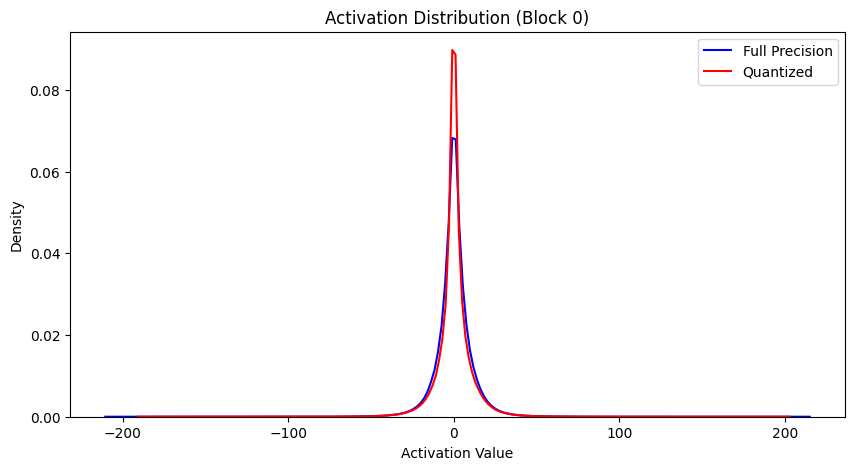

Block	KL Divergence	Cosine Similarity
0	0.0674		0.9814
MSE:	[0.8613803386688232]
Block 1


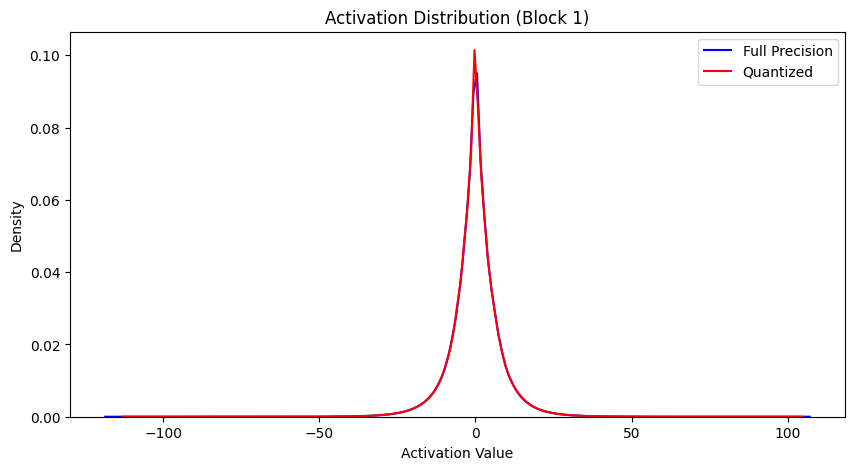

Block	KL Divergence	Cosine Similarity
1	0.0839		0.9830
MSE:	[0.8385639786720276]
Block 2


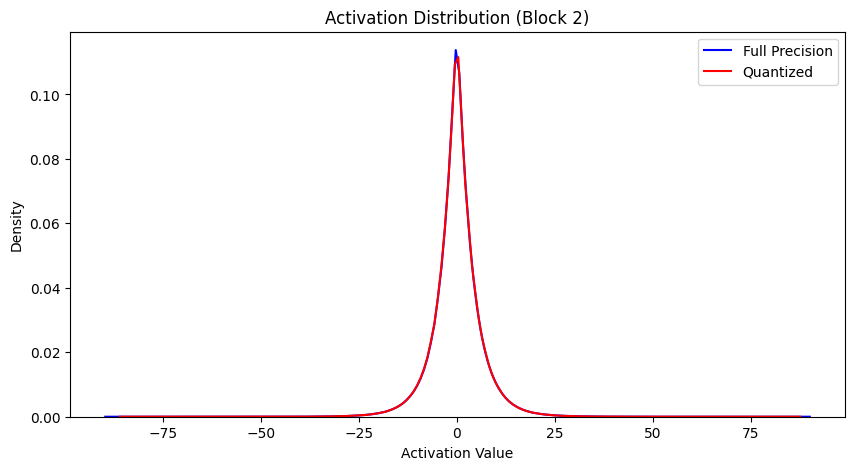

Block	KL Divergence	Cosine Similarity
2	0.1209		0.9635
MSE:	[0.8249897956848145]
Block 3


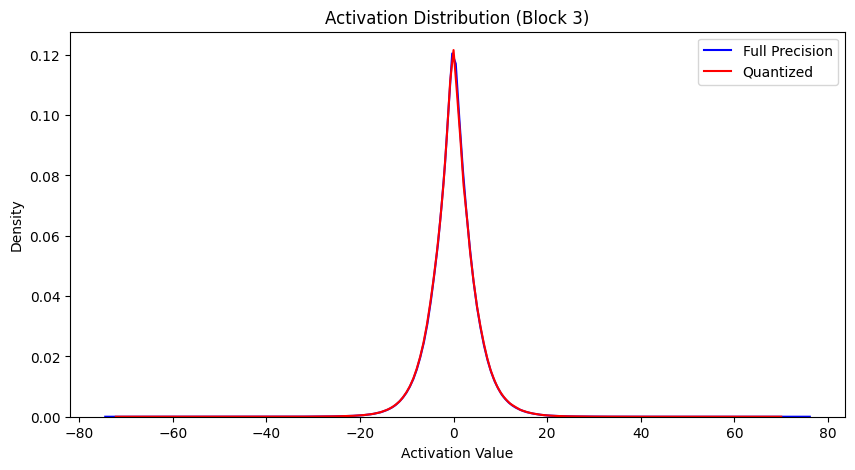

Block	KL Divergence	Cosine Similarity
3	0.1169		0.9668
MSE:	[0.9111111760139465]
Block 4


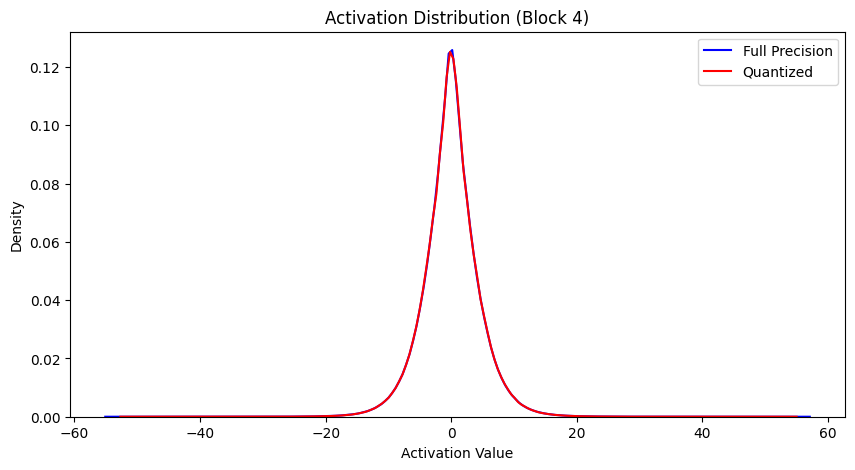

Block	KL Divergence	Cosine Similarity
4	0.1040		0.9632
MSE:	[0.9046738147735596]
Block 5


KeyboardInterrupt: 

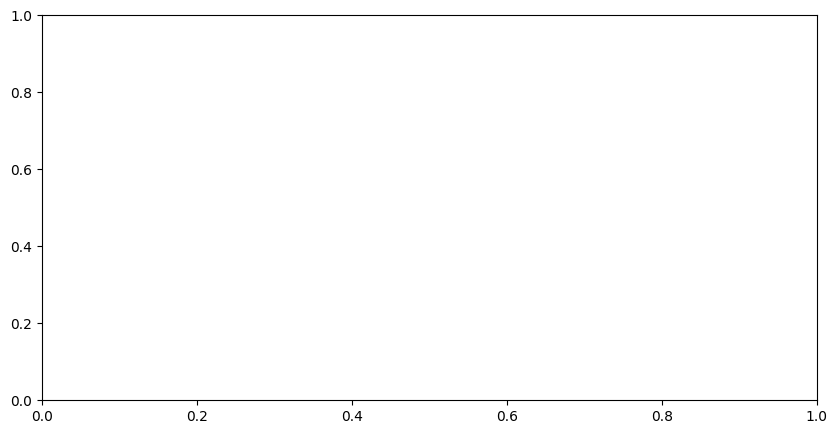

In [25]:
from copy import deepcopy

precision = 4
print(f"Initializing the quantizers using precision: {precision}")
quantization_config, embedding_layer_qconfig = get_quantization_config(precision=precision)
print("Quantization config initialized")

# ========== Quantization ==========
# Get the names of the modules
names, _ = zip(*list(model.named_modules()))

for i in range(12):
    print(f"Block {i}")

    layer_to_quantize = "transformer.blocks." + str(i) + ".attn"

    # Check if the layer to quantize is in the model
    assert layer_to_quantize in names, f"Layer {layer_to_quantize} not found in the model"

    if "embeddings" in layer_to_quantize:
        quantization_config = embedding_layer_qconfig

    model_dynamic = deepcopy(model)
    
    torch.quantization.quantize_dynamic(
        model_dynamic, {layer_to_quantize: quantization_config}, inplace=True
    )
    
    # Example usage
    plot_activation_distributions(model, model_dynamic, input_, i)

    # Get attention maps
    attn_quant = get_attention_maps(model_dynamic, input_)

    
    # Plot attention maps
    # plot_attention(attn_full, attn_quant, block=i, head=0)

    # Compute alignment metrics
    metrics = alignment_metrics(attn_full, attn_quant)

    # Print results
    print("Block\tKL Divergence\tCosine Similarity")
    print(f"{i}\t{metrics['kl'][i]:.4f}\t\t{metrics['cosine'][i]:.4f}")

    # Compute feature MSE
    mse_values = feature_mse(model, model_dynamic, input_, i)
    print(f"MSE:\t{mse_values}")
    

In [ ]:

layer_to_quantize = "transformer.blocks"

# Check if the layer to quantize is in the model
assert layer_to_quantize in names, f"Layer {layer_to_quantize} not found in the model"

if "embeddings" in layer_to_quantize:
    quantization_config = embedding_layer_qconfig

model_dynamic = deepcopy(model)

torch.quantization.quantize_dynamic(
    model_dynamic, {layer_to_quantize: quantization_config}, inplace=True
)

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModel, AutoTokenizer
import umap.umap_ as umap
from sklearn.metrics.pairwise import cosine_similarity


from sensitivity_utils import get_quantization_config
from copy import deepcopy

/data-4/users/mileriso/envs/.dev/lib/python3.10/site-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
2025-01-27 21:08:42.726825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738008522.745222 2821369 cuda_dnn.cc:8498] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738008522.750739 2821369 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load a pre-trained model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
quantized_model = deepcopy(model)

quantization_config, embedding_layer_qconfig = get_quantization_config(precision=2)

quantized_model = torch.quantization.quantize_dynamic(quantized_model, {torch.nn.Linear: quantization_config})

# Example input
text = "The quick brown fox jumps over the lazy dog."
inputs = tokenizer(text, return_tensors="pt", add_special_tokens=True)

In [8]:
# # Helper function for visualizing attention maps
# def visualize_attention_maps(model, inputs, layer_idx, head_idx):
#     outputs = model(**inputs, output_attentions=True)
#     attentions = outputs.attentions[layer_idx].detach().squeeze(0)  # Shape: [num_heads, seq_len, seq_len]
    
#     # Select attention from a specific head
#     attention_head = attentions[head_idx].cpu().numpy()
    
#     # Plot the attention map
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(attention_head, cmap="viridis", cbar=True, xticklabels=inputs["input_ids"].size(1),
#                 yticklabels=inputs["input_ids"].size(1))
#     plt.title(f"Attention Map - Layer {layer_idx + 1}, Head {head_idx + 1}")
#     plt.xlabel("Input Tokens")
#     plt.ylabel("Output Tokens")
#     plt.show()

# # Visualize attention map for Layer 0, Head 0
# visualize_attention_maps(model, inputs, layer_idx=0, head_idx=0),

# # Visualize attention map for Layer 0, Head 0
# visualize_attention_maps(quantized_model, inputs, layer_idx=0, head_idx=0)

original_outputs = model(**inputs, output_attentions=True)

print("Original model")
print(original_outputs.keys())

Original model
odict_keys(['last_hidden_state', 'pooler_output', 'attentions'])


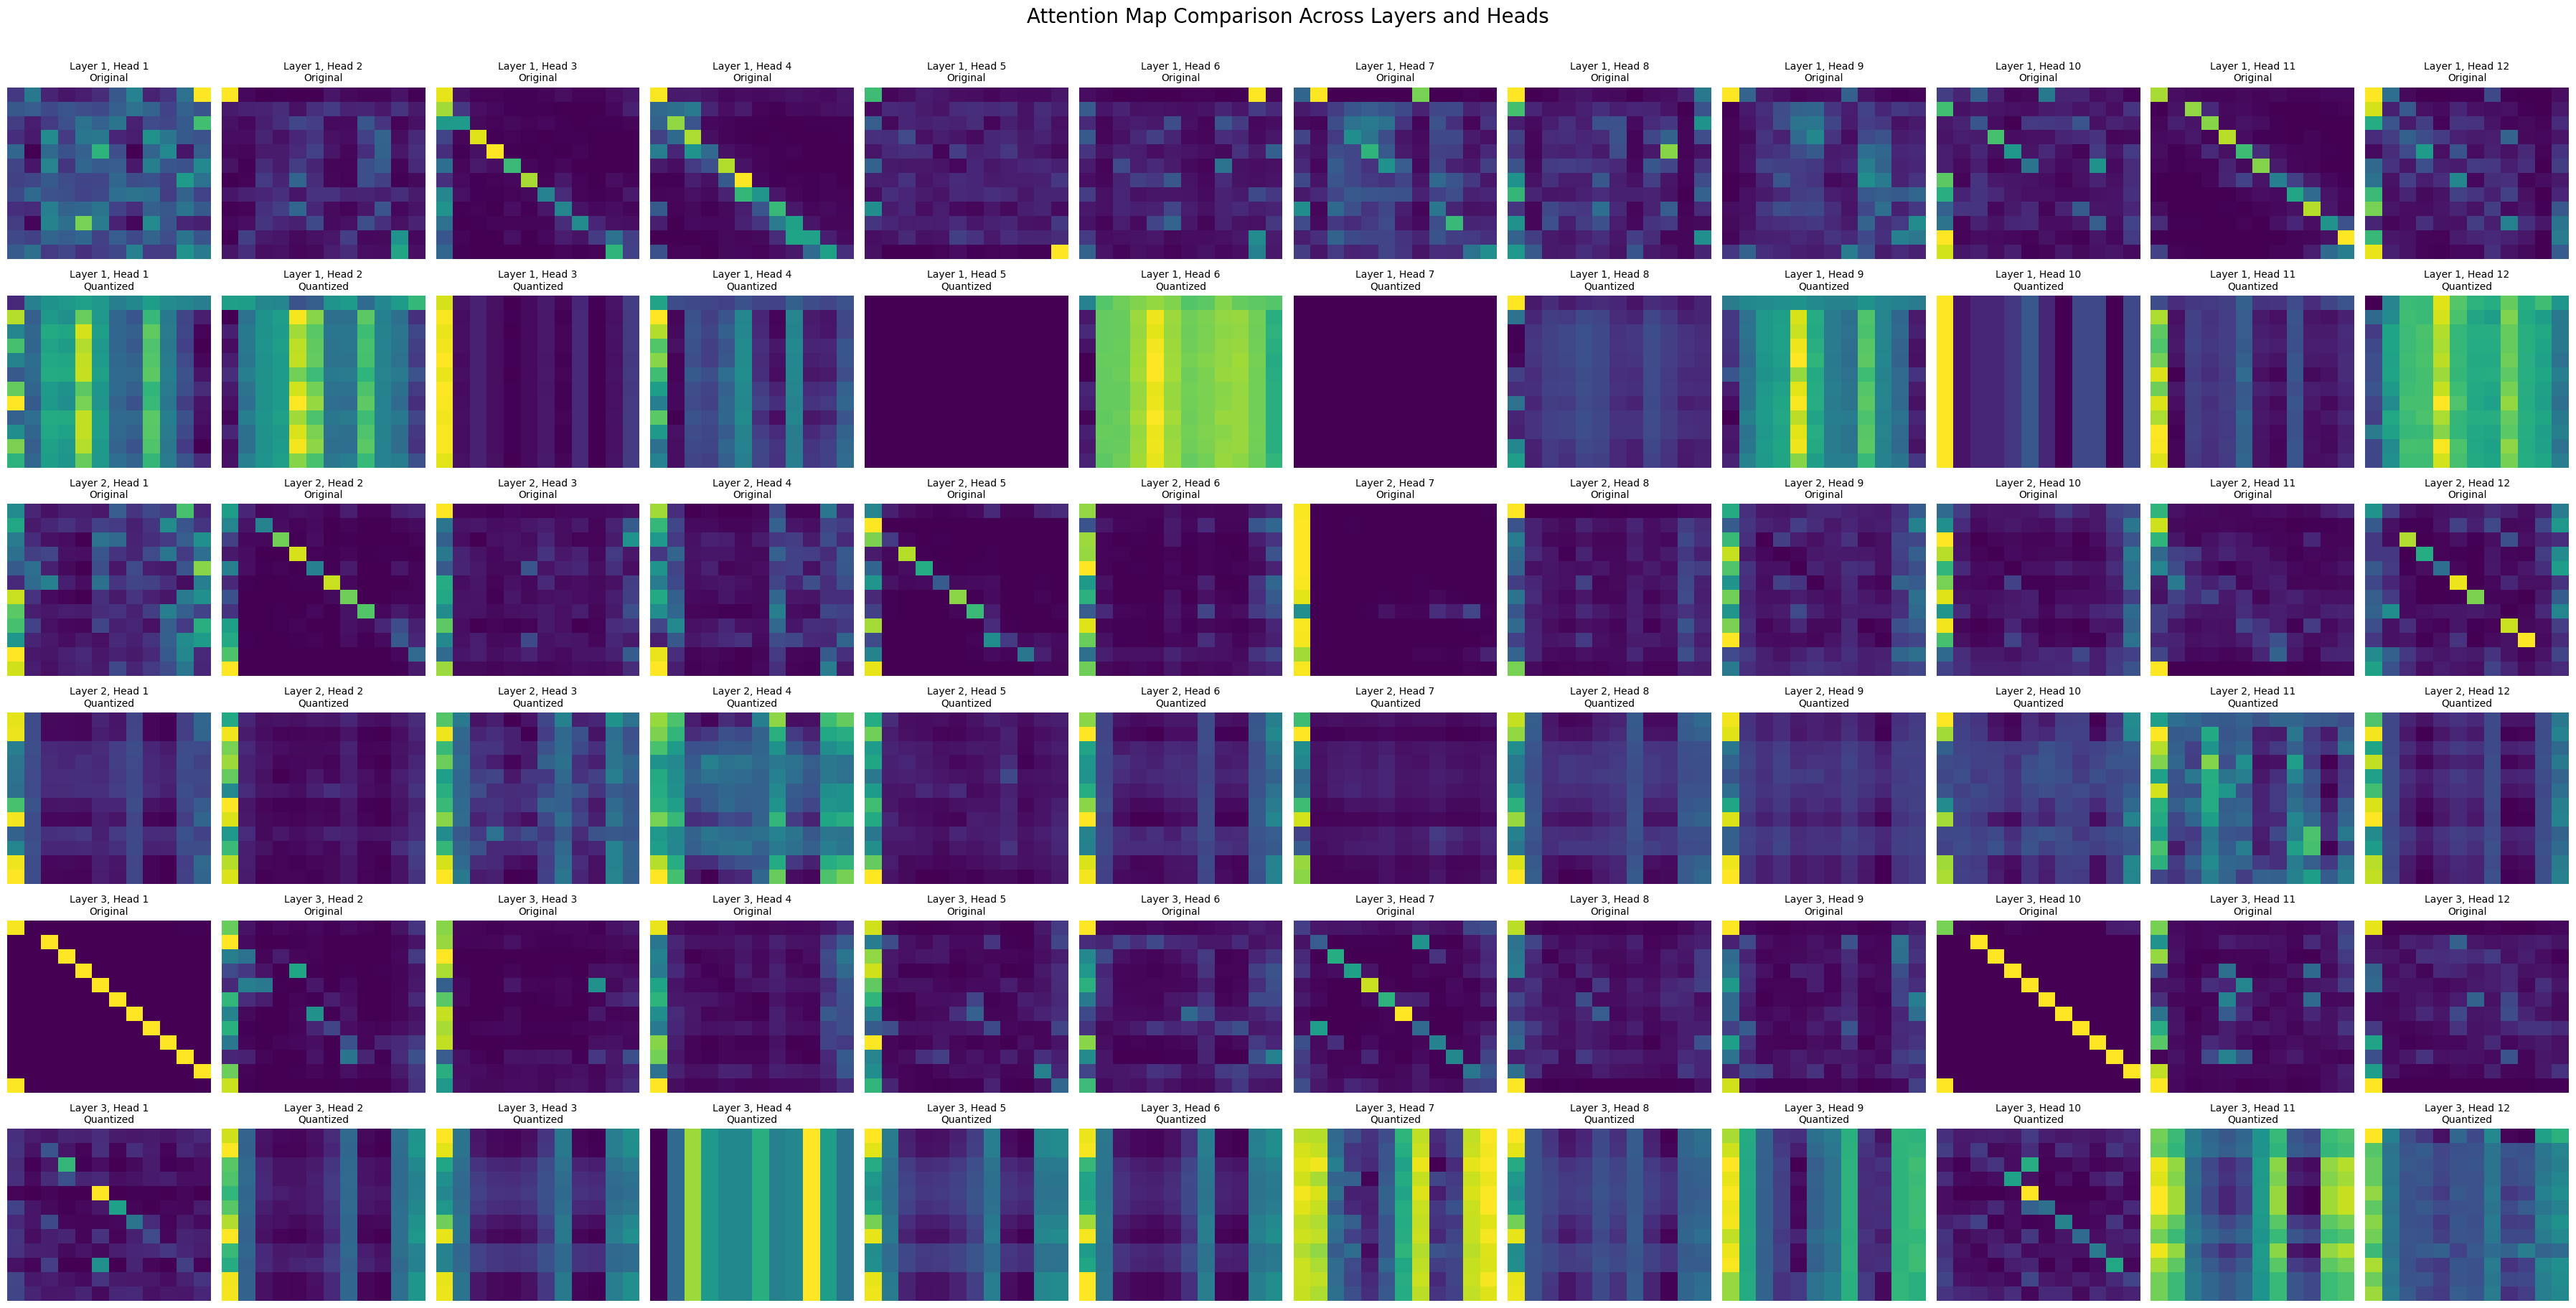

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to visualize attention maps across layers and heads
def visualize_attention_across_layers_and_heads(model, quantized_model, inputs, num_layers, num_heads):
    # Get attention maps for both models
    with torch.no_grad():
        original_outputs = model(**inputs, output_attentions=True)
        quantized_outputs = quantized_model(**inputs, output_attentions=True)
    
    # Initialize figure for visualization
    fig, axes = plt.subplots(nrows=num_layers * 2, ncols=num_heads, figsize=(num_heads * 3, num_layers * 6))
    fig.suptitle("Attention Map Comparison Across Layers and Heads", fontsize=20, y=1.01)

    for layer_idx in range(num_layers):
        for head_idx in range(num_heads):
            # Extract attention maps
            original_attention = original_outputs.attentions[layer_idx].detach().squeeze(0)[head_idx].cpu().numpy()
            quantized_attention = quantized_outputs.attentions[layer_idx].detach().squeeze(0)[head_idx].cpu().numpy()
            
            # Original attention map (row 2 * layer_idx)
            ax = axes[2 * layer_idx, head_idx]
            sns.heatmap(original_attention, cmap="viridis", cbar=False, ax=ax)
            ax.set_title(f"Layer {layer_idx + 1}, Head {head_idx + 1}\nOriginal", fontsize=10)
            ax.axis("off")
            
            # Quantized attention map (row 2 * layer_idx + 1)
            ax = axes[2 * layer_idx + 1, head_idx]
            sns.heatmap(quantized_attention, cmap="viridis", cbar=False, ax=ax)
            ax.set_title(f"Layer {layer_idx + 1}, Head {head_idx + 1}\nQuantized", fontsize=10)
            ax.axis("off")
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage
num_layers = 3  # Transformer typically has 12 layers
num_heads = 12   # Assuming the transformer has 12 attention heads
visualize_attention_across_layers_and_heads(model, quantized_model, inputs, num_layers, num_heads)


/data-4/users/mileriso/envs/.dev/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


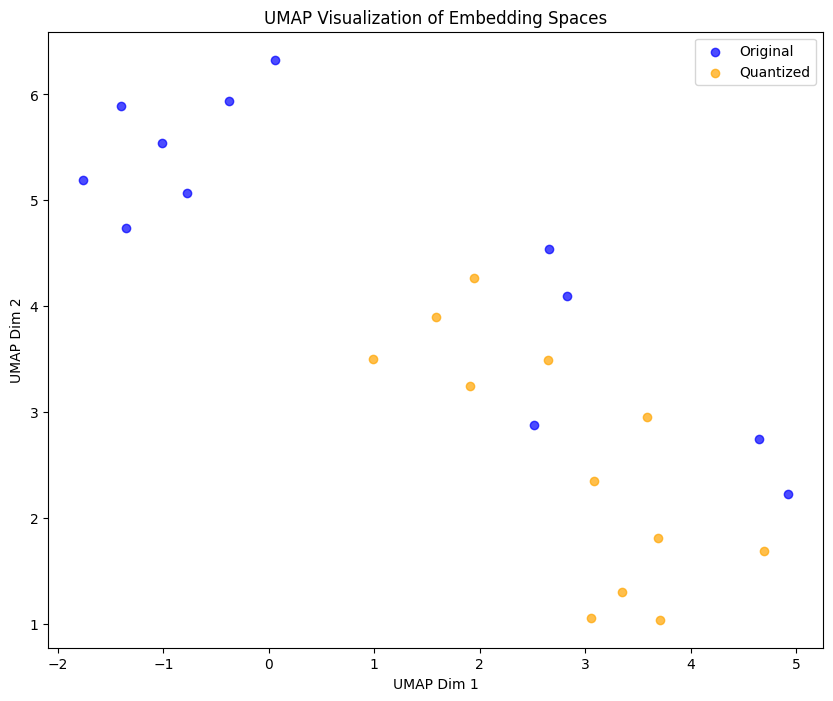

In [5]:
# Helper function for embedding visualization
def visualize_embeddings_with_umap(model, inputs, quantized_model):
    # Extract embeddings from the last hidden layer
    with torch.no_grad():
        embeddings = model(**inputs, output_hidden_states=True).hidden_states[-1].squeeze(0).cpu()
        quantized_embeddings = quantized_model(**inputs, output_hidden_states=True).hidden_states[-1].squeeze(0).cpu()
    
    # Fit UMAP and transform embeddings
    reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=42)
    combined_embeddings = torch.cat([embeddings, quantized_embeddings], dim=0)
    reduced_embeddings = reducer.fit_transform(combined_embeddings.numpy())
    
    # Split reduced embeddings into original and quantized
    orig_reduced, quantized_reduced = reduced_embeddings[:embeddings.size(0)], reduced_embeddings[embeddings.size(0):]
    
    # Plot UMAP results
    plt.figure(figsize=(10, 8))
    plt.scatter(orig_reduced[:, 0], orig_reduced[:, 1], label="Original", alpha=0.7, color='blue')
    plt.scatter(quantized_reduced[:, 0], quantized_reduced[:, 1], label="Quantized", alpha=0.7, color='orange')
    plt.title("UMAP Visualization of Embedding Spaces")
    plt.xlabel("UMAP Dim 1")
    plt.ylabel("UMAP Dim 2")
    plt.legend()
    plt.show()

# Visualize embedding spaces with UMAP
visualize_embeddings_with_umap(model, inputs, quantized_model)

In [6]:
# Helper function for similarity comparison
def compare_embedding_similarity(model, inputs, quantized_model):
    with torch.no_grad():
        embeddings = model(**inputs, output_hidden_states=True).hidden_states[-1].squeeze(0).cpu().numpy()
        quantized_embeddings = quantized_model(**inputs, output_hidden_states=True).hidden_states[-1].squeeze(0).cpu().numpy()
    
    # Compute pairwise cosine similarity
    similarity = cosine_similarity(embeddings, quantized_embeddings)
    mean_similarity = similarity.diagonal().mean()
    
    print(f"Mean Cosine Similarity Between Original and Quantized Embedding Spaces: {mean_similarity:.4f}")

# Compare embedding similarity
compare_embedding_similarity(model, inputs, quantized_model)


Mean Cosine Similarity Between Original and Quantized Embedding Spaces: 0.3773
